In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

lat_a=0.1163
lat_NL=48; lat_NT=48
lat_L=lat_a*lat_NL
hbarc = 1/197.327
lat_aInv=1/(lat_a*hbarc)

In [2]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/03_NpiScatteringWilson/dataPrepare/A15/data_aux/cfgs_CGWokringCPU'
with open(path,'r') as f:
    cfgs=f.read().splitlines()

def symmetrize(dat):
    dat_bw=np.roll(np.flip(dat,axis=1),1,axis=1)
    return((dat[:,:,0]+dat[:,:,5]) - (dat_bw[:,:,10]+dat_bw[:,:,15]))/4

d_jk=1
Nsrc=3000
path=f'/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_merge/NpiScatteringWilson_Nsrc={Nsrc}.h5'
data={}
with h5py.File(path) as f:    
    cfgs_all=[cfg.decode() for cfg in f['cfgs'][:]]
    cfgs_map=[cfgs_all.index(cfg) for cfg in cfgs]
    
    if True:
        cfgs_map=[cfgs_all.index(cfg) for cfg in cfgs_all]
    print(len(cfgs_map))
    
    for cont in f['data'].keys():
        if cont in ['N']:
            t=f[f'data/{cont}'][:,:,16]
            t=symmetrize(t)
            data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)
            continue
        if cont in ['P','P_hybrid']:
            t=f[f'data/{cont}'][:,:,0]
            t_bw=np.roll(np.flip(t,axis=1),1,axis=1)
            t=(t+t_bw)/2
            data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)
            continue
        t=f[f'data/{cont}'][:,:,0]
        t=symmetrize(t)
        data[cont]=yu.jackknife(t[cfgs_map],d=d_jk)

211


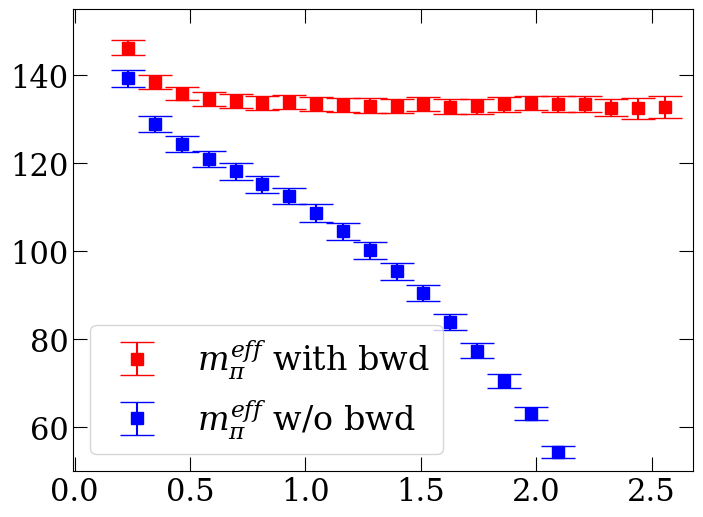

In [13]:
tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,lat_NT)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_pion_noB=yu.jackmap(func,np.real(data['P']))

def contaminate(dat):
    error=1/lat_aInv * 1*0
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t

meff_pion=contaminate(meff_pion)


fitmax_pion=24-tau
fitmins_pion=range(1,fitmax_pion-1)

m_pi=None
for mask in [None,'uncorrelated'][:1]:
    fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=8,sharey=True)
    chi2Size=9
    fig.suptitle(mask)

    ax=axs[0,0]
    xunit=lat_a; yunit=lat_aInv
    tmin=1; tmax=fitmax_pion
    # ax.set_ylim([125,155])
    ax.set_ylim([50,155])
    # ax.axhline(135,color='grey',ls='--')

    mean,err=yu.jackme(meff_pion)
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r',label=r'$m_\pi^{eff}$ with bwd')
    
    mean,err=yu.jackme(meff_pion_noB)
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='b',label=r'$m_\pi^{eff}$ w/o bwd')

    ax.legend()
    
    # plt.savefig('fig/c2pt_pion_correlated.pdf' if mask is None else 'fig/c2pt_pion_uncorrelated.pdf')

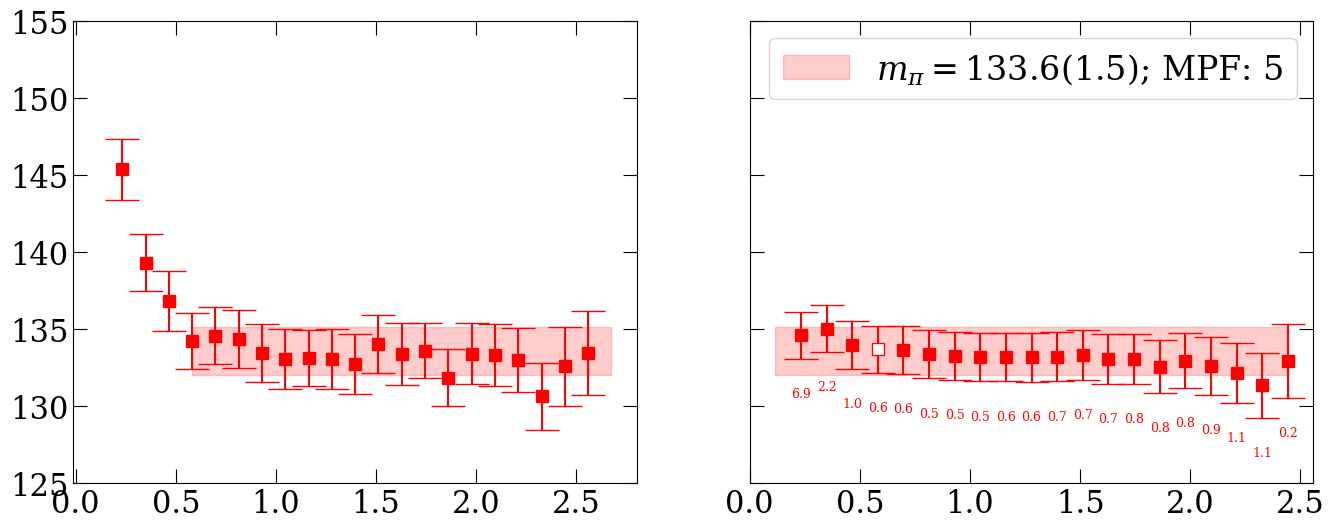

In [3]:
tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,lat_NT)
meff_pion=yu.jackmap(func,np.real(data['P']))

def contaminate(dat):
    error=1/lat_aInv * 1
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t

meff_pion=contaminate(meff_pion)

fitmax_pion=24-tau
fitmins_pion=range(1,fitmax_pion-1)

m_pi=None
for mask in [None,'uncorrelated'][:1]:
    pars0=[0.08]
    fits=[]
    for fitmin in fitmins_pion:
        tList=np.arange(fitmin,fitmax_pion)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff_pion[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    fits_pion=fits

    fig, axs = yu.getFigAxs(1,2,Lrow=6,Lcol=8,sharey=True)
    chi2Size=9
    fig.suptitle(mask)

    ax=axs[0,0]
    xunit=lat_a; yunit=lat_aInv
    tmin=1; tmax=fitmax_pion
    ax.set_ylim([125,155])
    # ax.axhline(135,color='grey',ls='--')

    mean,err=yu.jackme(meff_pion)
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

    pars_jk,props_jk=yu.jackMA(fits)
    if mask!='uncorrelated':
        mfits_pion=pars_jk[:,0]
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],23])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}')    
    # ax.legend(fontsize=16)

    ax=axs[0,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}') 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='r',mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color='r',size=chi2Size,ha='center') 
    ax.legend()
    
    plt.savefig('fig/c2pt_pion_correlated.pdf' if mask is None else 'fig/c2pt_pion_uncorrelated.pdf')

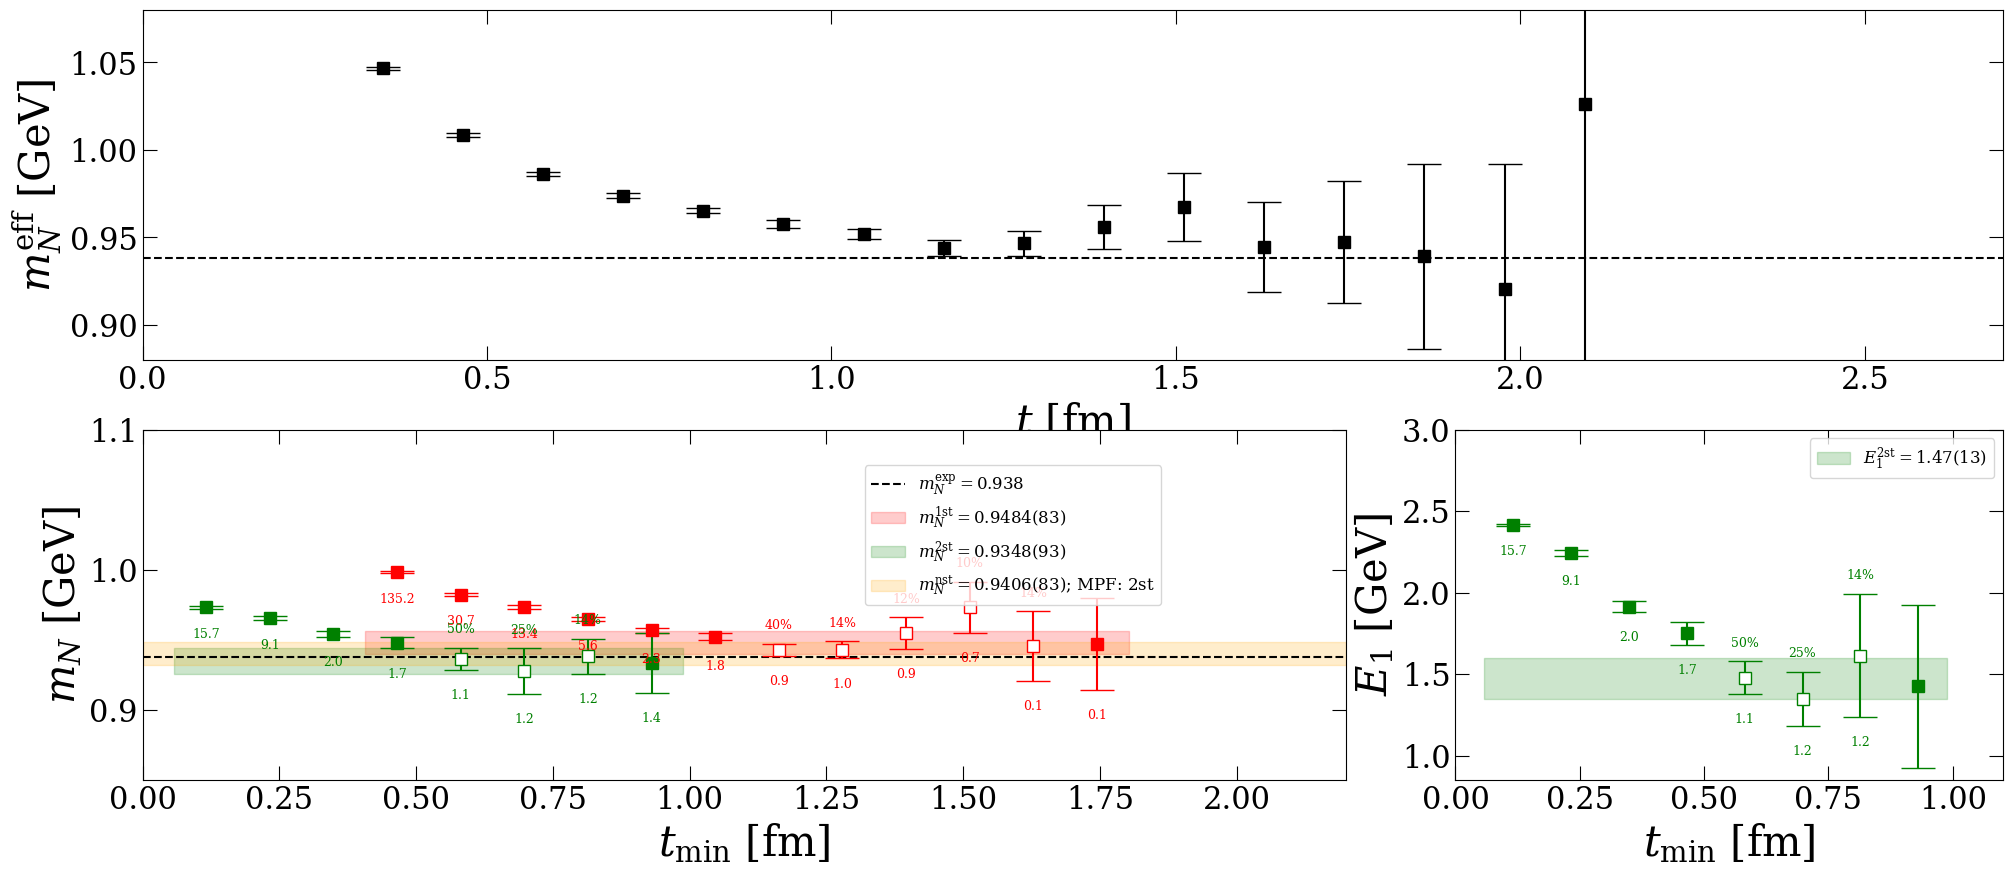

In [4]:
settings={
    'fitmins_1st':range(4,15+1),
    'fitmins_2st':range(1,8+1),
    'fitmins_3st':range(1,6+1),
    'ylim1':[0.6,1.7],
    'ylim1':[0.88,1.08],
    'ylim2':[0.85,1.1],
    'ylim3':[0.85,3.0],
    'xlim1':[0,2.7],
    'xlim2':[0,2.2],
    'xlim3':[0,1.1],
}

m_N=None

propThreshold=0.1

func=lambda c:np.log(c/np.roll(c,-1))
meff_N=yu.jackmap(func,np.real(data['N']))

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

xUnit=lat_a; yUnit=lat_aInv/1000
fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
(ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])

ax1.set_xlabel(r'$t$ [fm]')
ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
ax2.set_ylabel(r'$m_N$ [GeV]')
ax3.set_ylabel(r'$E_1$ [GeV]')
ax1.set_ylim(settings['ylim1'])
ax2.set_ylim(settings['ylim2'])
ax3.set_ylim(settings['ylim3'])
ax1.set_xlim(settings['xlim1'])
ax2.set_xlim(settings['xlim2'])
ax3.set_xlim(settings['xlim3'])

mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)

mEff_jk=meff_N
(mEff_mean,mEff_err)=yu.jackme(mEff_jk)
mEff_rela=np.abs(mEff_err/mEff_mean)
temp=[(i,rela) for i,rela in enumerate(mEff_rela) if rela>0.2 and i!=0]
fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1

tmin=1; tmax=fitmax+1
plt_x=np.arange(tmin,tmax)*xUnit; plt_y=mEff_mean[tmin:tmax]*yUnit; plt_err=mEff_err[tmin:tmax]*yUnit
ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

meffQ=True; corrQ=True; C2pt_jk=None

pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
DNpar=1 if meffQ else 0

fits_all=[]
# 1st fits
color='r'
fitmins=settings['fitmins_1st']
pars0=pars0_initial[:2-DNpar]
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_1st(tList,*pars)
        return func_C2pt_1st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    
pars_jk,props_jk=yu.jackMA(fits)
mfits1st_N=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
# for i,prop in enumerate(np.mean(props_jk,axis=0)):
#     if prop<0.1:
#         continue
#     fitmin,t_pars_jk,chi2_jk,Ndof=fits[i]
#     print(i,prop,fitmin*xUnit,np.mean(t_pars_jk,axis=0)[0]*yUnit,np.mean(chi2_jk)/Ndof,np.mean(chi2_jk),Ndof)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_mean,pars_err=yu.jackme(pars_jk)
pars0=pars_mean
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# 2st fits
color='g'
fitmins=settings['fitmins_2st']
pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_2st(tList,*pars)
        return func_C2pt_2st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
pars_jk,props_jk=yu.jackMA(fits)
mfits2st_N=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
pars0=yu.jackme(pars_jk)[0]
res=pars_jk.copy()
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
pars_mean,pars_err=yu.jackme(pars_jk)
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
    ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
color='orange'
pars_jk,props_jk=yu.jackMA(fits_all)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))
pars_mean,pars_err=yu.jackme(pars_jk)
plt_x=settings['xlim2']; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    

ax2.legend(loc=(0.6,0.5),fontsize=12)
ax3.legend(fontsize=12)
plt.savefig(f'fig/c2pt_nucleon_Nsrc={Nsrc}.pdf')

In [5]:
# scattering length <-> energy shift
def sl2es(mu, L, a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(mu, L, dE):
    return yu.fsolve2(lambda a0:sl2es(mu, L, a0)-dE, 0)


a32mpi_phy=(-86.3*1e-3,1.8*1e-3); a12mpi_phy=(169.8*1e-3,2.0*1e-3)
# a32mpi_phy=(-77.5*1e-3,3.5*1e-3); a12mpi_phy=(178.8*1e-3,3.8*1e-3) # pheLat

# a32mpi_pol=(-0.128,0.015); a12mpi_pol=(0.093,0.025) # old
a32mpi_pol=(-0.104,0.018); a12mpi_pol=(0.157,0.031)
a32mpi_delta=(-0.13,0.04)

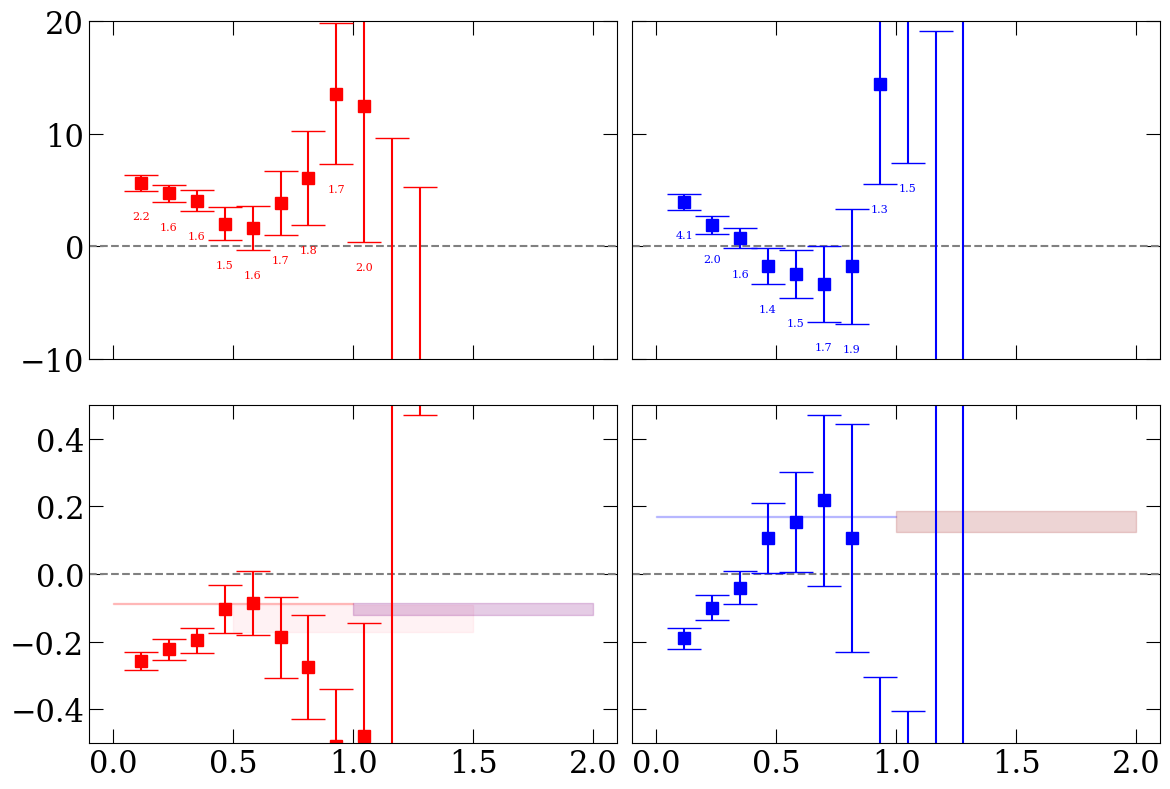

In [8]:
# 2 step 

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

def contaminate(dat):
    error=1/lat_aInv * 1/1000
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t

# meff_pion=contaminate(meff_pion)
# meff_N=contaminate(meff_N)
# meffp_32shift=contaminate(meffp_32shift)
# meffp_12shift=contaminate(meffp_12shift)


fitmax=16

fig, axs = yu.getFigAxs(2,2,Lrow=4,Lcol=6, sharex='col', sharey='row')

ax=axs[0,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[0,1].axhline(0,color='grey',ls='--',marker='')

# mean,err=yu.jackme(meffp_32shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

# mean,err=yu.jackme(meffp_12shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[1,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,c,r: func_CNpi(t,c,dE+mpi+mN,c*r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rtilde=lambda t,mpi,mN,dE,c,r: func_ratio(t,mpi,mN,dE,c,r)*(np.exp(mpi*(lat_NT-2*t))+1)
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,1,r)/func_ratio(t+1,mpi,mN,dE,1,r))

parsExtra_jk=np.concatenate([mfits_pion[:,None],mfits2st_N[:,None]],axis=1)
dt=1
for i_iso,iso in enumerate(['32','12']):
    pars0=[10/lat_aInv,1] if iso in ['32'] else [-5/lat_aInv,1]
    fitmins=range(1,fitmax-3-dt)
    fits=[]
    
    c=c_32 if iso in ['32'] else c_12
    r=c/c_Npi
    rlogr=np.log(r/np.roll(r,-1,axis=1))
    
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        y_jk=rlogr[:,tList]
        def fitfunc(pars):
            dE,r,mpi,mN=pars
            t=func_rlogr(tList,mpi,mN,dE,r)
            
            return t
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        # break

    color='r' if iso in ['32'] else 'b'
    for fit in fits:
        fitmin,pars_jk,chi2_jk,Ndof=fit
        pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
        # print(np.mean(pars_jk,axis=0))
        mean,err=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        ax=axs[0,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
        mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE)*mpi] for dE,r,mpi,mN in pars_jk])
        mean,err=yu.jackme(mpias_jk)
        
        ax=axs[1,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        
        # break
plt.tight_layout()
plt.savefig('fig/2step_rlogr.pdf')

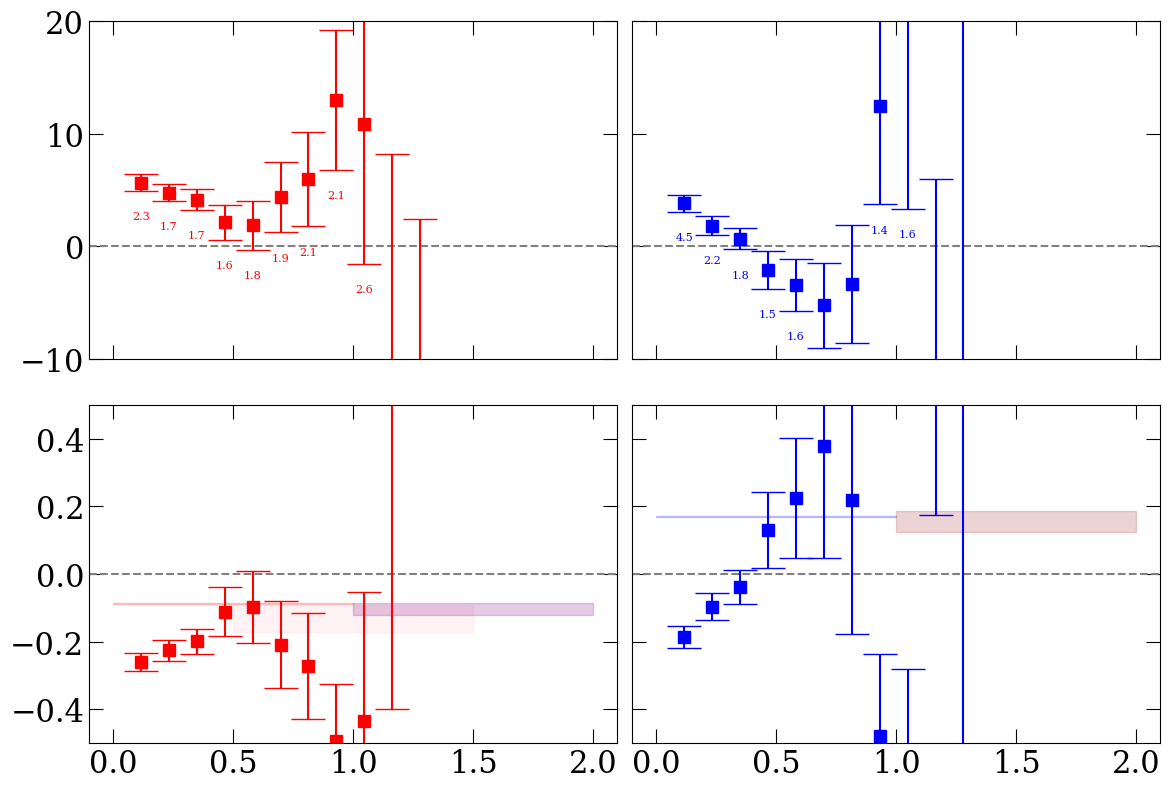

In [9]:
# 2 step 

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

def contaminate(dat):
    error=1/lat_aInv * 1/1000
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t

# meff_pion=contaminate(meff_pion)
# meff_N=contaminate(meff_N)
# meffp_32shift=contaminate(meffp_32shift)
# meffp_12shift=contaminate(meffp_12shift)


fitmax=16

fig, axs = yu.getFigAxs(2,2,Lrow=4,Lcol=6, sharex='col', sharey='row')

ax=axs[0,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[0,1].axhline(0,color='grey',ls='--',marker='')

# mean,err=yu.jackme(meffp_32shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

# mean,err=yu.jackme(meffp_12shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[1,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,c,r: func_CNpi(t,c,dE+mpi+mN,c*r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rtilde=lambda t,mpi,mN,dE,c,r: func_ratio(t,mpi,mN,dE,c,r)*(np.exp(mpi*(lat_NT-2*t))+1)
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,1,r)/func_ratio(t+1,mpi,mN,dE,1,r))

parsExtra_jk=np.concatenate([mfits_pion[:,None],mfits2st_N[:,None]],axis=1)
dt=1
for i_iso,iso in enumerate(['32','12']):
    pars0=[10/lat_aInv,1,1] if iso in ['32'] else [-5/lat_aInv,1,1]
    fitmins=range(1,fitmax-3-dt)
    fits=[]
    
    c=c_32 if iso in ['32'] else c_12
    r=c/c_Npi
    rlogr=np.log(r/np.roll(r,-1,axis=1))
    
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        y_jk=r[:,tList]
        def fitfunc(pars):
            dE,c,r,mpi,mN=pars
            t=func_ratio(tList,mpi,mN,dE,c,r)
            
            return t
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        # break

    color='r' if iso in ['32'] else 'b'
    for fit in fits:
        fitmin,pars_jk,chi2_jk,Ndof=fit
        pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
        # print(np.mean(pars_jk,axis=0))
        mean,err=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        ax=axs[0,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
        mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE)*mpi] for dE,c,r,mpi,mN in pars_jk])
        mean,err=yu.jackme(mpias_jk)
        
        ax=axs[1,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        
        # break
plt.tight_layout()
plt.savefig('fig/2step_r.pdf')

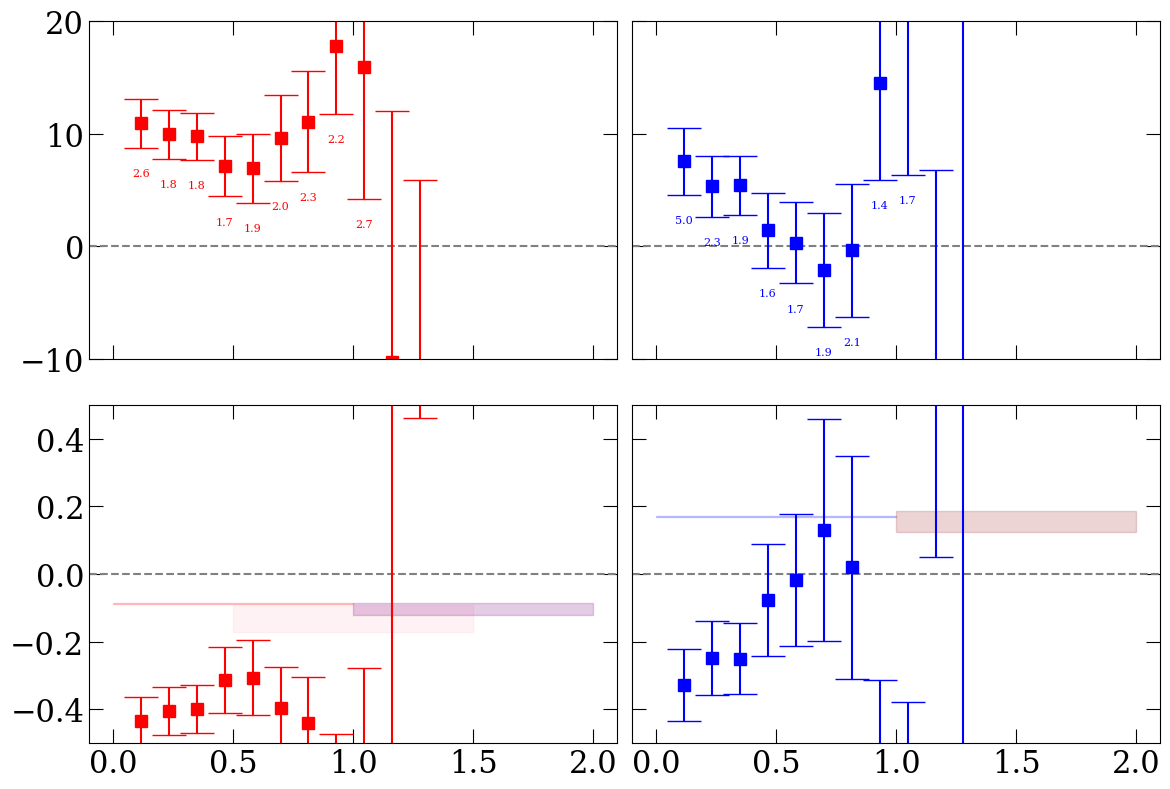

In [10]:
# 2 step 

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

fitmax=16

fig, axs = yu.getFigAxs(2,2,Lrow=4,Lcol=6, sharex='col', sharey='row')

ax=axs[0,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[0,1].axhline(0,color='grey',ls='--',marker='')

# mean,err=yu.jackme(meffp_32shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

# mean,err=yu.jackme(meffp_12shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[1,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,c,r: func_CNpi(t,c,dE+mpi+mN,c*r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rtilde=lambda t,mpi,mN,dE,c,r: func_ratio(t,mpi,mN,dE,c,r)*(np.exp(mpi*(lat_NT-2*t))+1)
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,1,r)/func_ratio(t+1,mpi,mN,dE,1,r))

def getNoise(dat):
    error=1/lat_aInv * 20
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return t

parsExtra_jk=np.concatenate([mfits_pion[:,None],mfits2st_N[:,None]],axis=1)
dt=1
for i_iso,iso in enumerate(['32','12']):
    pars0=[10/lat_aInv,1,1] if iso in ['32'] else [-5/lat_aInv,1,1]
    fitmins=range(1,fitmax-3-dt)
    fits=[]
    
    c=c_32 if iso in ['32'] else c_12
    r=c/c_Npi
    rlogr=np.log(r/np.roll(r,-1,axis=1))
    tList=np.arange(len(r[0]))
    factor=np.exp(mfits_pion[:,None]*(lat_NT-2*tList)[None,:])+1
    # factor+=getNoise(factor)
    # factor=np.exp(np.array([0.0788291653869804]*211)[:,None]*(lat_NT-2*tList)[None,:])+1
    rtilde=r*factor
    
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        y_jk=rtilde[:,tList]
        def fitfunc(pars):
            dE,c,r,mpi,mN=pars
            t=func_rtilde(tList,0.0788291653869804,mN,dE,c,r)
            
            return t
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        # break

    color='r' if iso in ['32'] else 'b'
    for fit in fits:
        fitmin,pars_jk,chi2_jk,Ndof=fit
        pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
        # print(np.mean(pars_jk,axis=0))
        mean,err=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        ax=axs[0,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
        mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE)*mpi] for dE,c,r,mpi,mN in pars_jk])
        mean,err=yu.jackme(mpias_jk)
        
        ax=axs[1,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        
        # break
plt.tight_layout()
plt.savefig('fig/2step_rtilde.pdf')

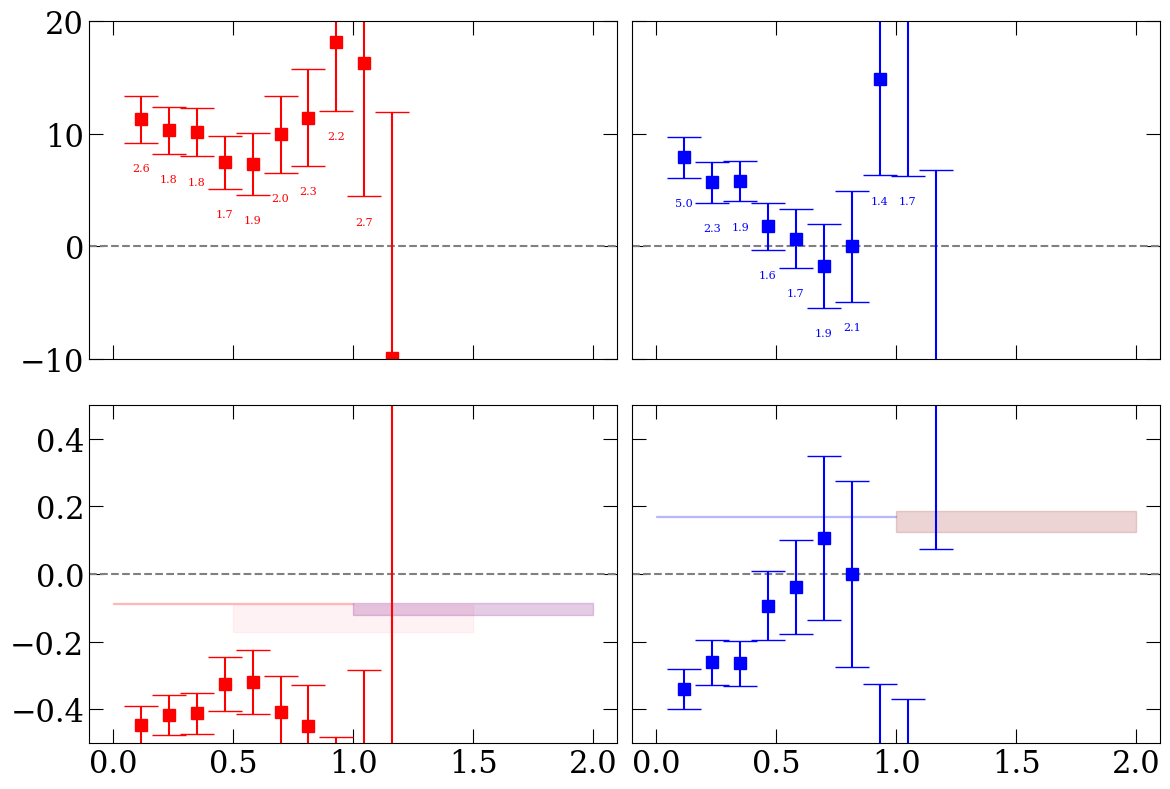

In [11]:
# 2 step 

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

fitmax=16

fig, axs = yu.getFigAxs(2,2,Lrow=4,Lcol=6, sharex='col', sharey='row')

ax=axs[0,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[0,1].axhline(0,color='grey',ls='--',marker='')

# mean,err=yu.jackme(meffp_32shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

# mean,err=yu.jackme(meffp_12shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[1,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,c,r: func_CNpi(t,c,dE+mpi+mN,c*r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rtilde=lambda t,mpi,mN,dE,c,r: func_ratio(t,mpi,mN,dE,c,r)*(np.exp(mpi*(lat_NT-2*t))+1)
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,1,r)/func_ratio(t+1,mpi,mN,dE,1,r))

def getNoise(dat):
    error=1/lat_aInv * 20
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return t

parsExtra_jk=np.concatenate([mfits_pion[:,None],mfits2st_N[:,None]],axis=1)
dt=1
fitmax-=dt
for i_iso,iso in enumerate(['32','12']):
    pars0=[10/lat_aInv,1] if iso in ['32'] else [-5/lat_aInv,1]
    fitmins=range(1,fitmax-3-dt)
    fits=[]
    
    c=c_32 if iso in ['32'] else c_12
    r=c/c_Npi
    rlogr=np.log(r/np.roll(r,-1,axis=1))
    tList=np.arange(len(r[0]))
    factor=np.exp(mfits_pion[:,None]*(lat_NT-2*tList)[None,:])+1
    rtilde=r*factor
    drtilde=(rtilde - np.roll(rtilde,-dt,axis=1))
    rdrtilde=(drtilde/np.roll(drtilde,dt,axis=1))
    
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        y_jk=drtilde[:,tList]
        def fitfunc(pars):
            dE,c,mpi,mN=pars
            t=(func_rtilde(tList,mpi,mN,dE,c,0) - func_rtilde(tList+dt,mpi,mN,dE,c,0))
            
            return t
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        # break

    color='r' if iso in ['32'] else 'b'
    for fit in fits:
        fitmin,pars_jk,chi2_jk,Ndof=fit
        pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
        # print(np.mean(pars_jk,axis=0))
        mean,err=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        ax=axs[0,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
        mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE)*mpi] for dE,c,mpi,mN in pars_jk])
        mean,err=yu.jackme(mpias_jk)
        
        ax=axs[1,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        
        # break
plt.tight_layout()
plt.savefig('fig/2step_drtilde.pdf')

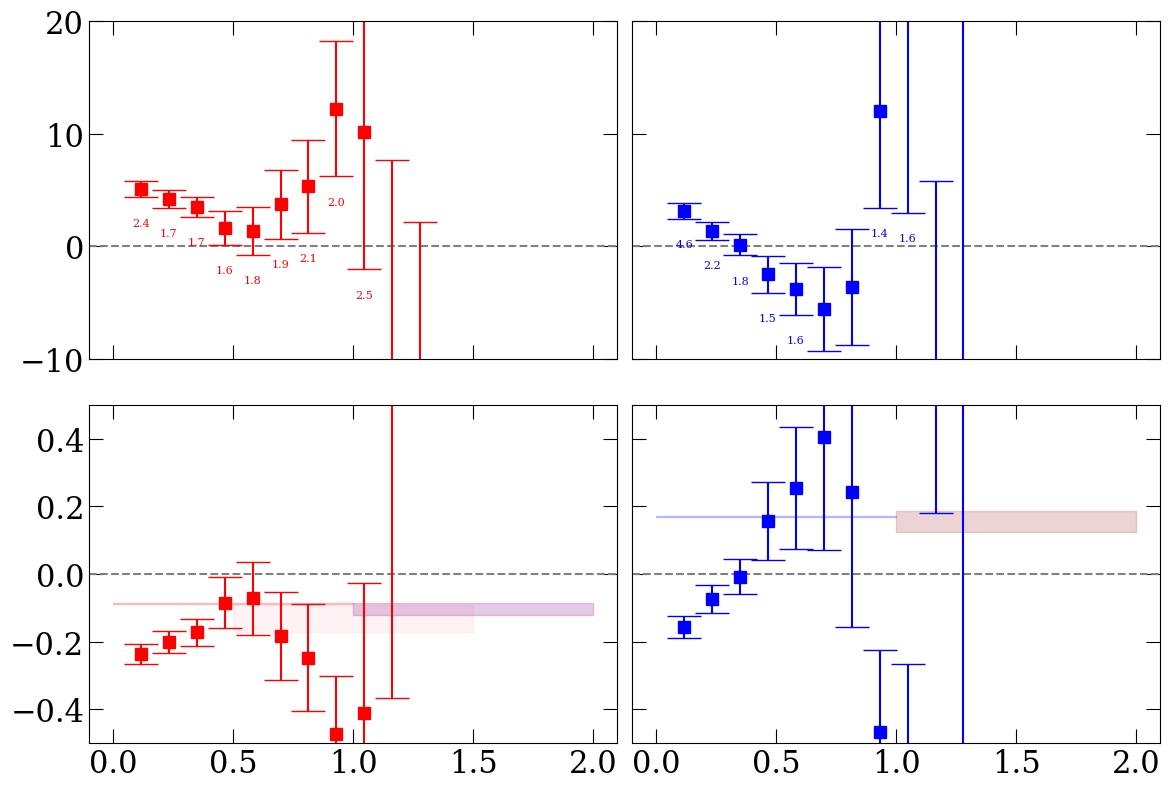

In [12]:
# 2 step 

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

fitmax=16

fig, axs = yu.getFigAxs(2,2,Lrow=4,Lcol=6, sharex='col', sharey='row')

ax=axs[0,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[0,1].axhline(0,color='grey',ls='--',marker='')

# mean,err=yu.jackme(meffp_32shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

# mean,err=yu.jackme(meffp_12shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[1,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,c,r: func_CNpi(t,c,dE+mpi+mN,c*r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rtilde=lambda t,mpi,mN,dE,c,r: func_ratio(t,mpi,mN,dE,c,r)*(np.exp(mpi*(lat_NT-2*t))+1)
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,1,r)/func_ratio(t+1,mpi,mN,dE,1,r))

def getNoise(dat):
    error=1/lat_aInv * 20
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return t

parsExtra_jk=np.concatenate([mfits_pion[:,None],mfits2st_N[:,None]],axis=1)
dt=1
fitmax-=dt
for i_iso,iso in enumerate(['32','12']):
    pars0=[10/lat_aInv,1] if iso in ['32'] else [-5/lat_aInv,1]
    fitmins=range(1,fitmax-3)
    fits=[]
    
    c=c_32 if iso in ['32'] else c_12
    r=c/c_Npi
    rlogr=np.log(r/np.roll(r,-1,axis=1))
    tList=np.arange(len(r[0]))
    factor=np.exp(mfits_pion[:,None]*(lat_NT-2*tList)[None,:])+1
    rtilde=r*factor
    drtilde=(rtilde - np.roll(rtilde,-dt,axis=1))
    rdrtilde=(drtilde/np.roll(drtilde,dt,axis=1))
    
    dr=drtilde/factor
    
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        y_jk=dr[:,tList]
        def fitfunc(pars):
            dE,c,mpi,mN=pars
            t=(func_rtilde(tList,mpi,mN,dE,c,0) - func_rtilde(tList+dt,mpi,mN,dE,c,0))/(np.exp(mpi*(lat_NT-2*tList))+1)
            
            return t
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        # break

    color='r' if iso in ['32'] else 'b'
    for fit in fits:
        fitmin,pars_jk,chi2_jk,Ndof=fit
        pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
        # print(np.mean(pars_jk,axis=0))
        mean,err=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        ax=axs[0,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
        mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE)*mpi] for dE,c,mpi,mN in pars_jk])
        mean,err=yu.jackme(mpias_jk)
        
        ax=axs[1,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        
        # break
plt.tight_layout()
plt.savefig('fig/2step_dr.pdf')

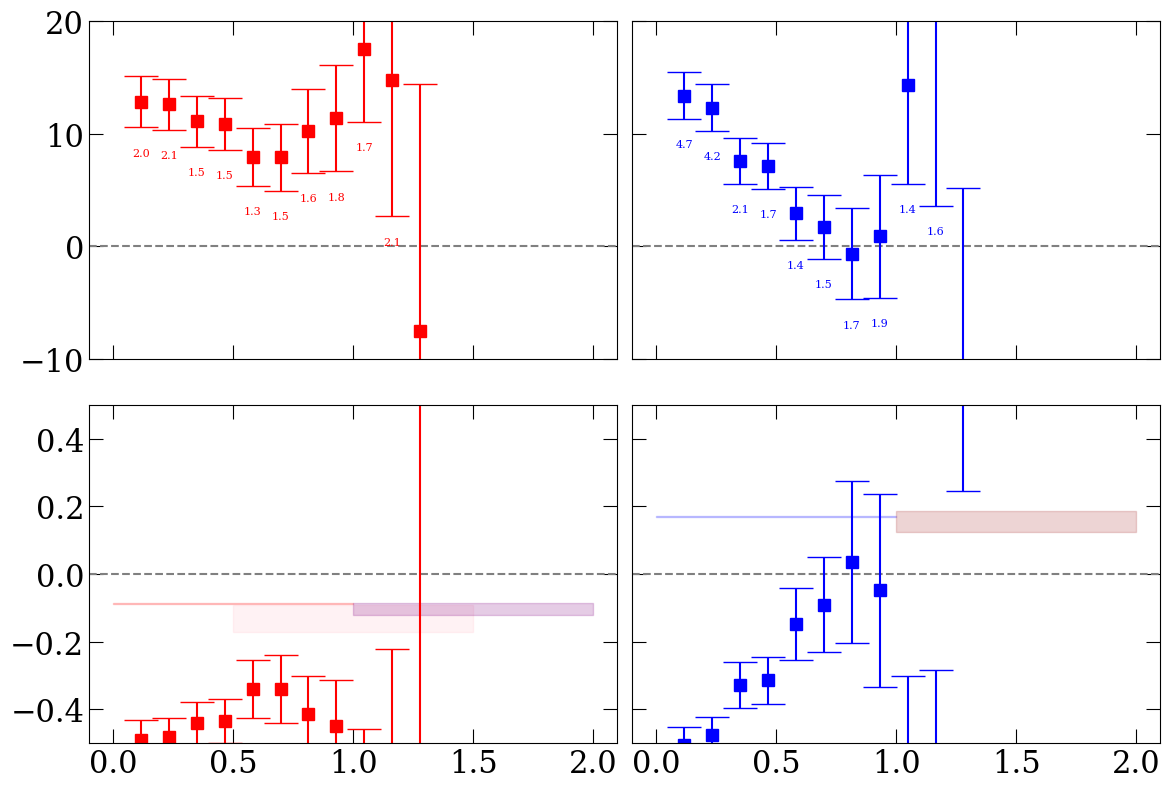

In [13]:
# 2 step 

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

fitmax=16

fig, axs = yu.getFigAxs(2,2,Lrow=4,Lcol=6, sharex='col', sharey='row')

ax=axs[0,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[0,1].axhline(0,color='grey',ls='--',marker='')

# mean,err=yu.jackme(meffp_32shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

# mean,err=yu.jackme(meffp_12shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[1,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,c,r: func_CNpi(t,c,dE+mpi+mN,c*r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rtilde=lambda t,mpi,mN,dE,c,r: func_ratio(t,mpi,mN,dE,c,r)*(np.exp(mpi*(lat_NT-2*t))+1)
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,1,r)/func_ratio(t+1,mpi,mN,dE,1,r))

def getNoise(dat):
    error=1/lat_aInv * 20
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return t

parsExtra_jk=np.concatenate([mfits_pion[:,None],mfits2st_N[:,None]],axis=1)
dt=1
fitmax-=dt
for i_iso,iso in enumerate(['32','12']):
    pars0=[10/lat_aInv] if iso in ['32'] else [-5/lat_aInv]
    fitmins=range(dt,fitmax-3)
    fits=[]
    
    c=c_32 if iso in ['32'] else c_12
    r=c/c_Npi
    rlogr=np.log(r/np.roll(r,-1,axis=1))
    tList=np.arange(len(r[0]))
    factor=np.exp(mfits_pion[:,None]*(lat_NT-2*tList)[None,:])+1
    rtilde=r*factor
    drtilde=(rtilde - np.roll(rtilde,-dt,axis=1))
    rdrtilde=(drtilde/np.roll(drtilde,dt,axis=1))
    
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        y_jk=rdrtilde[:,tList]
        def fitfunc(pars):
            dE,mpi,mN=pars
            t=(func_rtilde(tList,mpi,mN,dE,1,0) - func_rtilde(tList+dt,mpi,mN,dE,1,0))/(func_rtilde(tList-dt,mpi,mN,dE,1,0) - func_rtilde(tList,mpi,mN,dE,1,0))
            return t
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        # break

    color='r' if iso in ['32'] else 'b'
    for fit in fits:
        fitmin,pars_jk,chi2_jk,Ndof=fit
        pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
        # print(np.mean(pars_jk,axis=0))
        mean,err=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        ax=axs[0,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
        mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE)*mpi] for dE,mpi,mN in pars_jk])
        mean,err=yu.jackme(mpias_jk)
        
        ax=axs[1,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        
        # break
plt.tight_layout()
plt.savefig('fig/2step_rdrtilde.pdf')

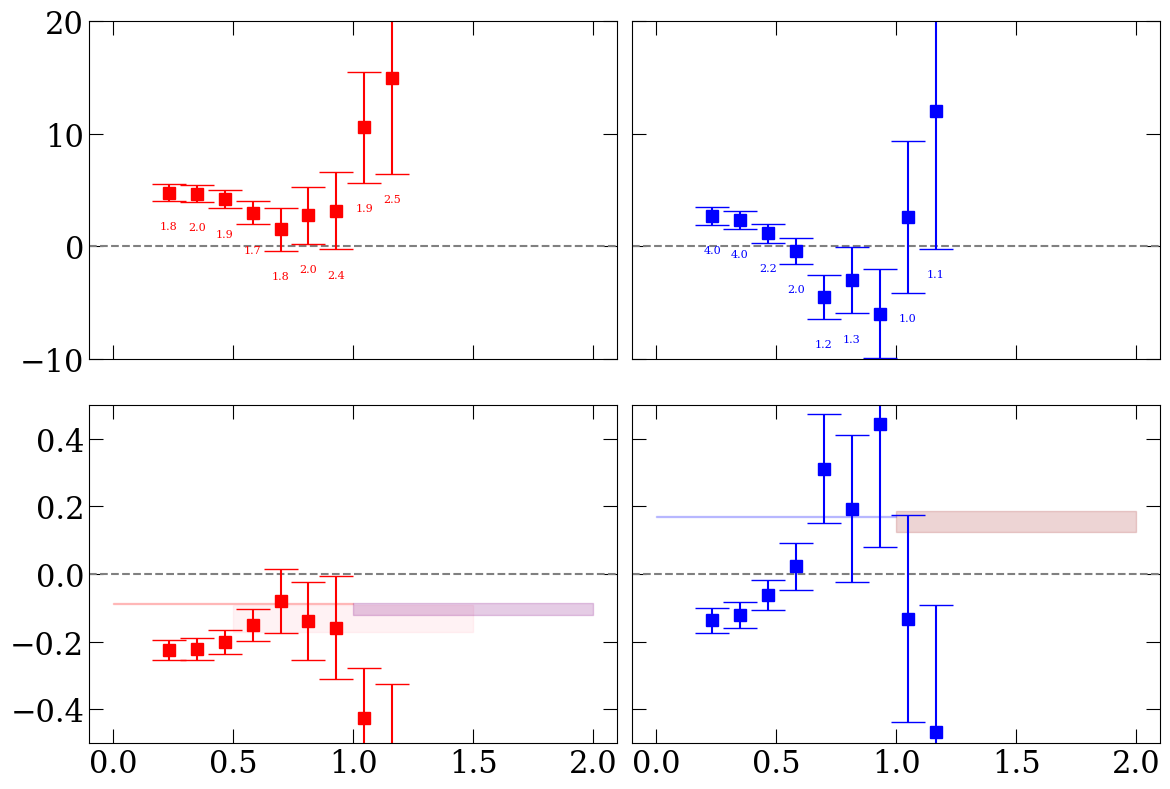

In [14]:
# 2 step 

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

fitmax=16

fig, axs = yu.getFigAxs(2,2,Lrow=4,Lcol=6, sharex='col', sharey='row')

ax=axs[0,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[0,1].axhline(0,color='grey',ls='--',marker='')

# mean,err=yu.jackme(meffp_32shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

# mean,err=yu.jackme(meffp_12shift)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[1,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,c,r: func_CNpi(t,c,dE+mpi+mN,c*r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rtilde=lambda t,mpi,mN,dE,c,r: func_ratio(t,mpi,mN,dE,c,r)*(np.exp(mpi*(lat_NT-2*t))+1)
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,1,r)/func_ratio(t+1,mpi,mN,dE,1,r))

def getNoise(dat):
    error=1/lat_aInv * 20
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return t

parsExtra_jk=np.concatenate([mfits_pion[:,None],mfits2st_N[:,None]],axis=1)
dt=2
fitmax-=dt
for i_iso,iso in enumerate(['32','12']):
    pars0=[10/lat_aInv] if iso in ['32'] else [-5/lat_aInv]
    fitmins=range(dt,fitmax-3)
    fits=[]
    
    c=c_32 if iso in ['32'] else c_12
    r=c/c_Npi
    rlogr=np.log(r/np.roll(r,-1,axis=1))
    tList=np.arange(len(r[0]))
    factor=np.exp(mfits_pion[:,None]*(lat_NT-2*tList)[None,:])+1
    rtilde=r*factor
    drtilde=(rtilde - np.roll(rtilde,-dt,axis=1))
    rdrtilde=(drtilde/np.roll(drtilde,dt,axis=1))
    
    dr=drtilde/factor
    rdr=(dr/np.roll(dr,dt,axis=1))
    
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        y_jk=rdr[:,tList]
        def fitfunc(pars):
            dE,mpi,mN=pars
            t=((func_rtilde(tList,mpi,mN,dE,1,0) - func_rtilde(tList+dt,mpi,mN,dE,1,0))/(np.exp(mpi*(lat_NT-2*tList))+1)) \
                /((func_rtilde(tList-dt,mpi,mN,dE,1,0) - func_rtilde(tList,mpi,mN,dE,1,0))/(np.exp(mpi*(lat_NT-2*(tList-dt)))+1))
            return t
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,parsExtra_jk=parsExtra_jk)
        
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        # break

    color='r' if iso in ['32'] else 'b'
    for fit in fits:
        fitmin,pars_jk,chi2_jk,Ndof=fit
        pars_jk=np.concatenate([pars_jk,parsExtra_jk],axis=1)
        # print(np.mean(pars_jk,axis=0))
        mean,err=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        
        ax=axs[0,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
        mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE)*mpi] for dE,mpi,mN in pars_jk])
        mean,err=yu.jackme(mpias_jk)
        
        ax=axs[1,i_iso]
        plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
        ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color=color)
        
        # break
plt.tight_layout()
plt.savefig('fig/2step_rdr.pdf')

In [41]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,lat_NT)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

def func(c,mpi,mN):
    ts=np.arange(len(c))
    ct=c * np.exp(mpi*(lat_NT-ts)) * np.exp(mN*ts)
    t=(ct - np.roll(ct,1))/(np.roll(ct,-1) - ct)
    t=t[1:-1]
    t=np.array([yu.fsolve2(lambda dE:(1-np.exp(dE+2*m1))/(np.exp(-dE-2*m1)-1)-ele, 0.004) for ele,m1,m2 in zip(t,mpi[1:-1],mN[1:-1])])
    return t
meff_32shift=np.array([func(c,mpi,mN) for c,mpi,mN in zip(c_32,meff_pi,meff_N)])
meff_12shift=np.array([func(c,mpi,mN) for c,mpi,mN in zip(c_12,meff_pi,meff_N)])

fitmin=0; fitmax=24
c=c_32[:,fitmin:fitmax]
r=c/c_Npi[:,fitmin:fitmax]
factor=np.exp(mfits_pion[:,None]*(lat_NT-2*tList)[None,:])+1
rtilde=r*factor
drtilde=(rtilde - np.roll(rtilde,-dt,axis=1))[:,:-dt]
rdrtilde=(drtilde/np.roll(drtilde,dt,axis=1))[:,dt:]

func_ratio=lambda t,mpi,mN,dE,c,r: func_CNpi(t,c,dE+mpi+mN,c*r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rtilde=lambda t,mpi,mN,dE,c,r: func_ratio(t,mpi,mN,dE,c,r)*(np.exp(mpi*(lat_NT-2*t))+1)
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,1,r)/func_ratio(t+1,mpi,mN,dE,1,r))
def func(rdrt,mpi,mN):
    ts=np.arange(len(c))
    
    t=np.array([yu.fsolve2(lambda dE:(1-np.exp(dE+2*m1))/(np.exp(-dE-2*m1)-1)-ele, 0.004) for ele,m1,m2 in zip(t,mpi[1:-1],mN[1:-1])])
    return t

def contaminate(dat):
    error=1/lat_aInv * 1
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t

# meff_pion=contaminate(meff_pion)
# meff_N=contaminate(meff_N)
# meffp_32shift=contaminate(meffp_32shift)
# meffp_12shift=contaminate(meffp_12shift)


fitmax=18

fig, axs = yu.getFigAxs(4,2,Lrow=4,Lcol=6, sharex='col', sharey='row')
ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1; tmax=fitmax
ax.set_ylim([125,155])
# ax.axhline(135,color='grey',ls='--',marker='')
# axs[0,1].axhline(135,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_pion)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[1,0]
ax.set_ylim([900,1200])
# ax.axhline(938,color='grey',ls='--',marker='')
# axs[1,1].axhline(938,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_N)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[2,0]
ax.set_ylim([-10,20])
# ax.set_ylim([-1000,2000])
ax.axhline(0,color='grey',ls='--',marker='')
axs[2,1].axhline(0,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_32shift)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(meff_12shift)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[3,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[3,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


# func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
# func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
# func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

# func_ratio=lambda t,mpi,mN,dE,r: func_CNpi(t,1,dE+mpi+mN,r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
# func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,r)/func_ratio(t+1,mpi,mN,dE,r))

# pars0=[140/lat_aInv,1000/lat_aInv,10/lat_aInv,-5/lat_aInv,1,1]
# fitmins=range(1,fitmax-3)
# fits=[]
# for fitmin in fitmins:
#     tList=np.arange(fitmin,fitmax)
#     y_jk=np.concatenate([meff_pion[:,fitmin:fitmax],meff_N[:,fitmin:fitmax],meffp_32shift[:,fitmin:fitmax],meffp_12shift[:,fitmin:fitmax]],axis=1)
#     def fitfunc(pars):
#         mpi,mN,dE32,dE12,r32,r12=pars
#         t=[mpi]*len(tList)+[mN]*len(tList)+list(func_rlogr(tList,mpi,mN,dE32,r32))+list(func_rlogr(tList,mpi,mN,dE12,r12))
#         return t
    
#     sizes=[len(tList)]*(len(y_jk[0])//len(tList))
#     sizeTotal=len(y_jk[0])
#     mask=np.zeros([sizeTotal,sizeTotal])
#     ind=0
#     for i in range(4):
#         mask[ind:ind+sizes[i],ind:ind+sizes[i]]+=1
#         ind+=sizes[i]
#     pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
#     # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
    
#     pars0=np.mean(pars_jk,axis=0)
#     fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    
#     # break

# for fit in fits:
#     fitmin,pars_jk,chi2_jk,Ndof=fit
#     mean,err=yu.jackme(pars_jk)
#     chi2R=np.mean(chi2_jk)/Ndof

#     ax=axs[0,1]
#     plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='g')
#     ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
#     ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color='g',size=chi2Size,ha='center') 
    
#     ax=axs[1,1]
#     plt_x=fitmin*xunit; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='g')
    
#     ax=axs[2,1]
#     plt_x=fitmin*xunit; plt_y=mean[2]*yunit; plt_yerr=err[2]*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='r')
#     plt_x=fitmin*xunit; plt_y=mean[3]*yunit; plt_yerr=err[3]*yunit
#     ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='b')
    
    
#     mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE32)*mpi,es2sl(1/(1/mpi+1/mN),lat_NL,dE12)*mpi] for mpi,mN,dE32,dE12,r32,r12 in pars_jk])
#     mean,err=yu.jackme(mpias_jk)
    
#     ax=axs[3,0]
#     plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
#     ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='r')
    
#     ax=axs[3,1]
#     plt_x=fitmin*xunit; plt_y=mean[1]*1; plt_yerr=err[1]*1
#     ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='b')
    
#     # break

ValueError: operands could not be broadcast together with shapes (211,24) (211,3) 

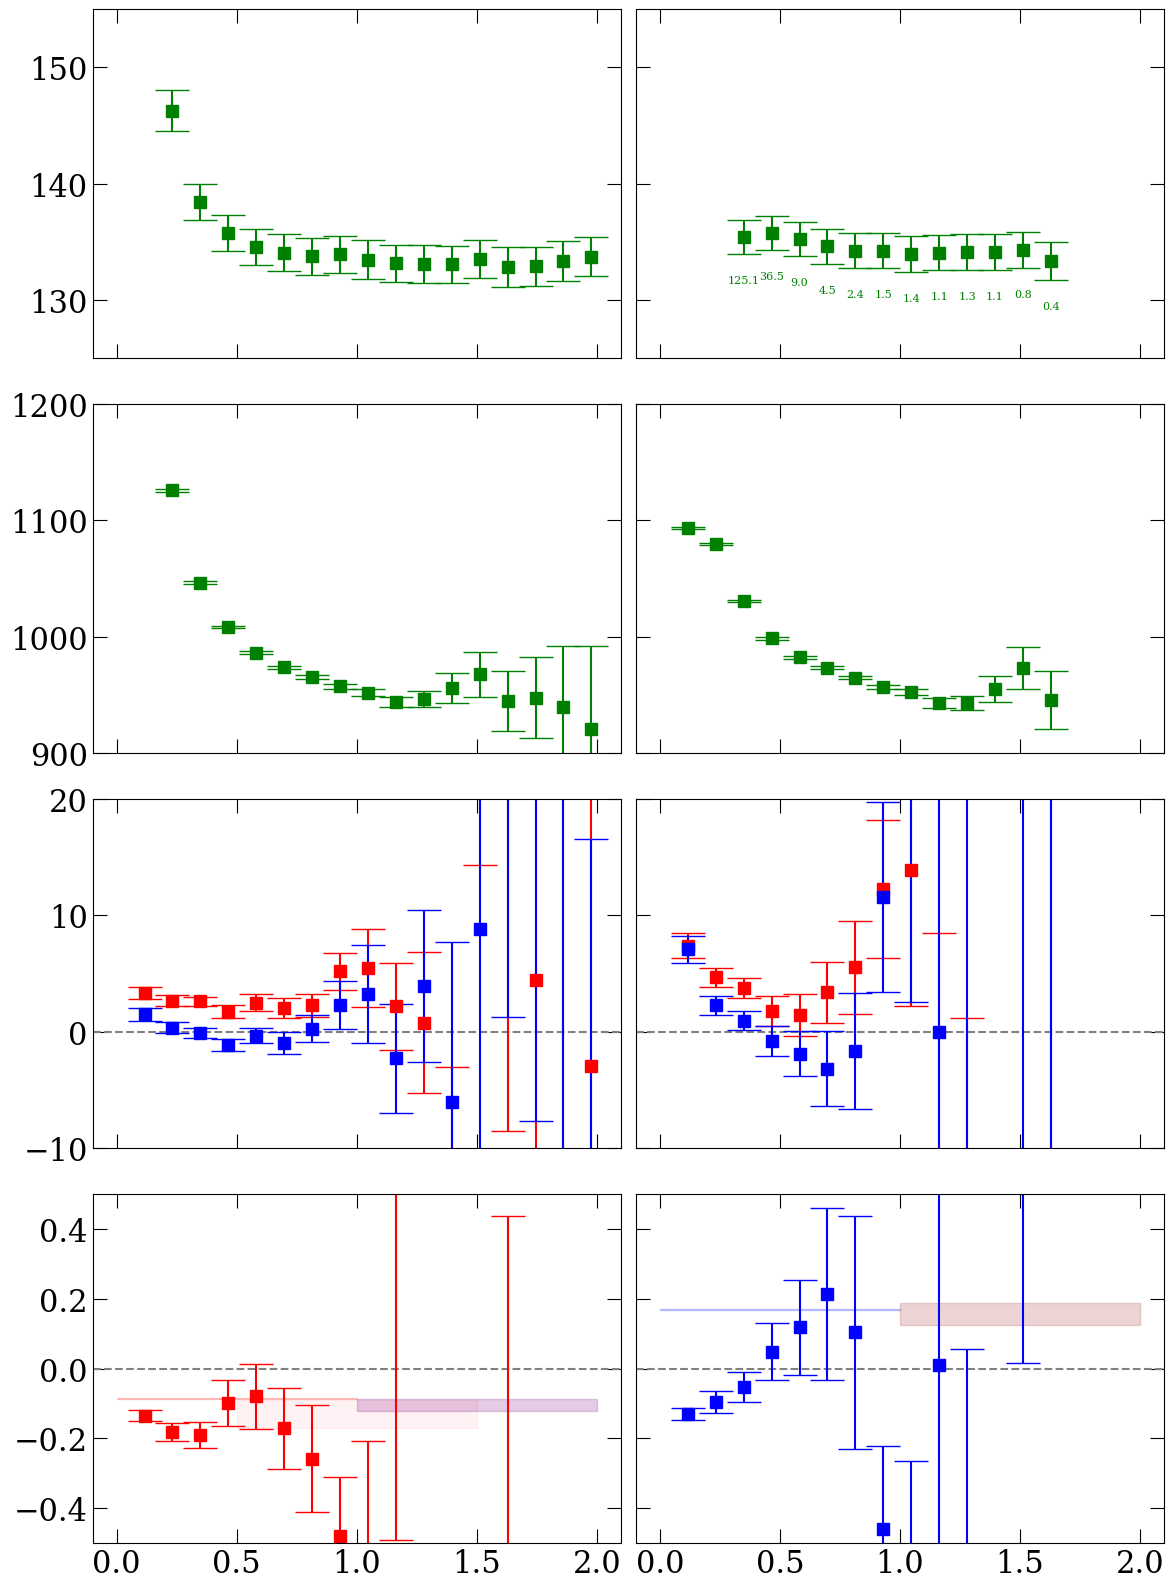

In [8]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

def contaminate(dat):
    error=1/lat_aInv * 1/1000
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t

meff_pion=contaminate(meff_pion)
meff_N=contaminate(meff_N)
meffp_32shift=contaminate(meffp_32shift)
meffp_12shift=contaminate(meffp_12shift)


fitmax=18

fig, axs = yu.getFigAxs(4,2,Lrow=4,Lcol=6, sharex='col', sharey='row')
ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1; tmax=fitmax
ax.set_ylim([125,155])
# ax.axhline(135,color='grey',ls='--',marker='')
# axs[0,1].axhline(135,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_pion)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[1,0]
ax.set_ylim([900,1200])
# ax.axhline(938,color='grey',ls='--',marker='')
# axs[1,1].axhline(938,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_N)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[2,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[2,1].axhline(0,color='grey',ls='--',marker='')

mean,err=yu.jackme(meffp_32shift)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(meffp_12shift)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[3,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[3,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,r: func_CNpi(t,1,dE+mpi+mN,r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,r)/func_ratio(t+1,mpi,mN,dE,r))

pars0=[140/lat_aInv,1000/lat_aInv,10/lat_aInv,-5/lat_aInv,1,1]
fitmins=range(1,fitmax-3)
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    y_jk=np.concatenate([meff_pion[:,fitmin:fitmax],meff_N[:,fitmin:fitmax],meffp_32shift[:,fitmin:fitmax],meffp_12shift[:,fitmin:fitmax]],axis=1)
    def fitfunc(pars):
        mpi,mN,dE32,dE12,r32,r12=pars
        t=[mpi]*len(tList)+[mN]*len(tList)+list(func_rlogr(tList,mpi,mN,dE32,r32))+list(func_rlogr(tList,mpi,mN,dE12,r12))
        return t
    
    sizes=[len(tList)]*(len(y_jk[0])//len(tList))
    sizeTotal=len(y_jk[0])
    mask=np.zeros([sizeTotal,sizeTotal])
    ind=0
    for i in range(4):
        mask[ind:ind+sizes[i],ind:ind+sizes[i]]+=1
        ind+=sizes[i]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
    
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    
    # break

for fit in fits:
    fitmin,pars_jk,chi2_jk,Ndof=fit
    mean,err=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof

    ax=axs[0,1]
    plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='g')
    ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
    ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color='g',size=chi2Size,ha='center') 
    
    ax=axs[1,1]
    plt_x=fitmin*xunit; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='g')
    
    ax=axs[2,1]
    plt_x=fitmin*xunit; plt_y=mean[2]*yunit; plt_yerr=err[2]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='r')
    plt_x=fitmin*xunit; plt_y=mean[3]*yunit; plt_yerr=err[3]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='b')
    
    
    mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE32)*mpi,es2sl(1/(1/mpi+1/mN),lat_NL,dE12)*mpi] for mpi,mN,dE32,dE12,r32,r12 in pars_jk])
    mean,err=yu.jackme(mpias_jk)
    
    ax=axs[3,0]
    plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='r')
    
    ax=axs[3,1]
    plt_x=fitmin*xunit; plt_y=mean[1]*1; plt_yerr=err[1]*1
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='b')
    
    # break

plt.tight_layout()
plt.savefig('fig/joint.pdf')

In [ ]:
# two-step fits

coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

def contaminate(dat):
    error=1/lat_aInv * 1/1000
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t

meff_pion=contaminate(meff_pion)
meff_N=contaminate(meff_N)
meffp_32shift=contaminate(meffp_32shift)
meffp_12shift=contaminate(meffp_12shift)


fitmax=18

fig, axs = yu.getFigAxs(4,2,Lrow=4,Lcol=6, sharex='col', sharey='row')
ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1; tmax=fitmax
ax.set_ylim([125,155])
# ax.axhline(135,color='grey',ls='--',marker='')
# axs[0,1].axhline(135,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_pion)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[1,0]
ax.set_ylim([900,1200])
# ax.axhline(938,color='grey',ls='--',marker='')
# axs[1,1].axhline(938,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_N)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[2,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[2,1].axhline(0,color='grey',ls='--',marker='')

mean,err=yu.jackme(meffp_32shift)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(meffp_12shift)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[3,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[3,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,r: func_CNpi(t,1,dE+mpi+mN,r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,r)/func_ratio(t+1,mpi,mN,dE,r))

pars0=[140/lat_aInv,1000/lat_aInv,10/lat_aInv,-5/lat_aInv,1,1]
fitmins=range(1,fitmax-3)
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    y_jk=np.concatenate([meff_pion[:,fitmin:fitmax],meff_N[:,fitmin:fitmax],meffp_32shift[:,fitmin:fitmax],meffp_12shift[:,fitmin:fitmax]],axis=1)
    def fitfunc(pars):
        mpi,mN,dE32,dE12,r32,r12=pars
        t=[mpi]*len(tList)+[mN]*len(tList)+list(func_rlogr(tList,mpi,mN,dE32,r32))+list(func_rlogr(tList,mpi,mN,dE12,r12))
        return t
    
    sizes=[len(tList)]*(len(y_jk[0])//len(tList))
    sizeTotal=len(y_jk[0])
    mask=np.zeros([sizeTotal,sizeTotal])
    ind=0
    for i in range(4):
        mask[ind:ind+sizes[i],ind:ind+sizes[i]]+=1
        ind+=sizes[i]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
    
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    
    # break

for fit in fits:
    fitmin,pars_jk,chi2_jk,Ndof=fit
    mean,err=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof

    ax=axs[0,1]
    plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='g')
    ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
    ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color='g',size=chi2Size,ha='center') 
    
    ax=axs[1,1]
    plt_x=fitmin*xunit; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='g')
    
    ax=axs[2,1]
    plt_x=fitmin*xunit; plt_y=mean[2]*yunit; plt_yerr=err[2]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='r')
    plt_x=fitmin*xunit; plt_y=mean[3]*yunit; plt_yerr=err[3]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='b')
    
    
    mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE32)*mpi,es2sl(1/(1/mpi+1/mN),lat_NL,dE12)*mpi] for mpi,mN,dE32,dE12,r32,r12 in pars_jk])
    mean,err=yu.jackme(mpias_jk)
    
    ax=axs[3,0]
    plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='r')
    
    ax=axs[3,1]
    plt_x=fitmin*xunit; plt_y=mean[1]*1; plt_yerr=err[1]*1
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='b')
    
    # break

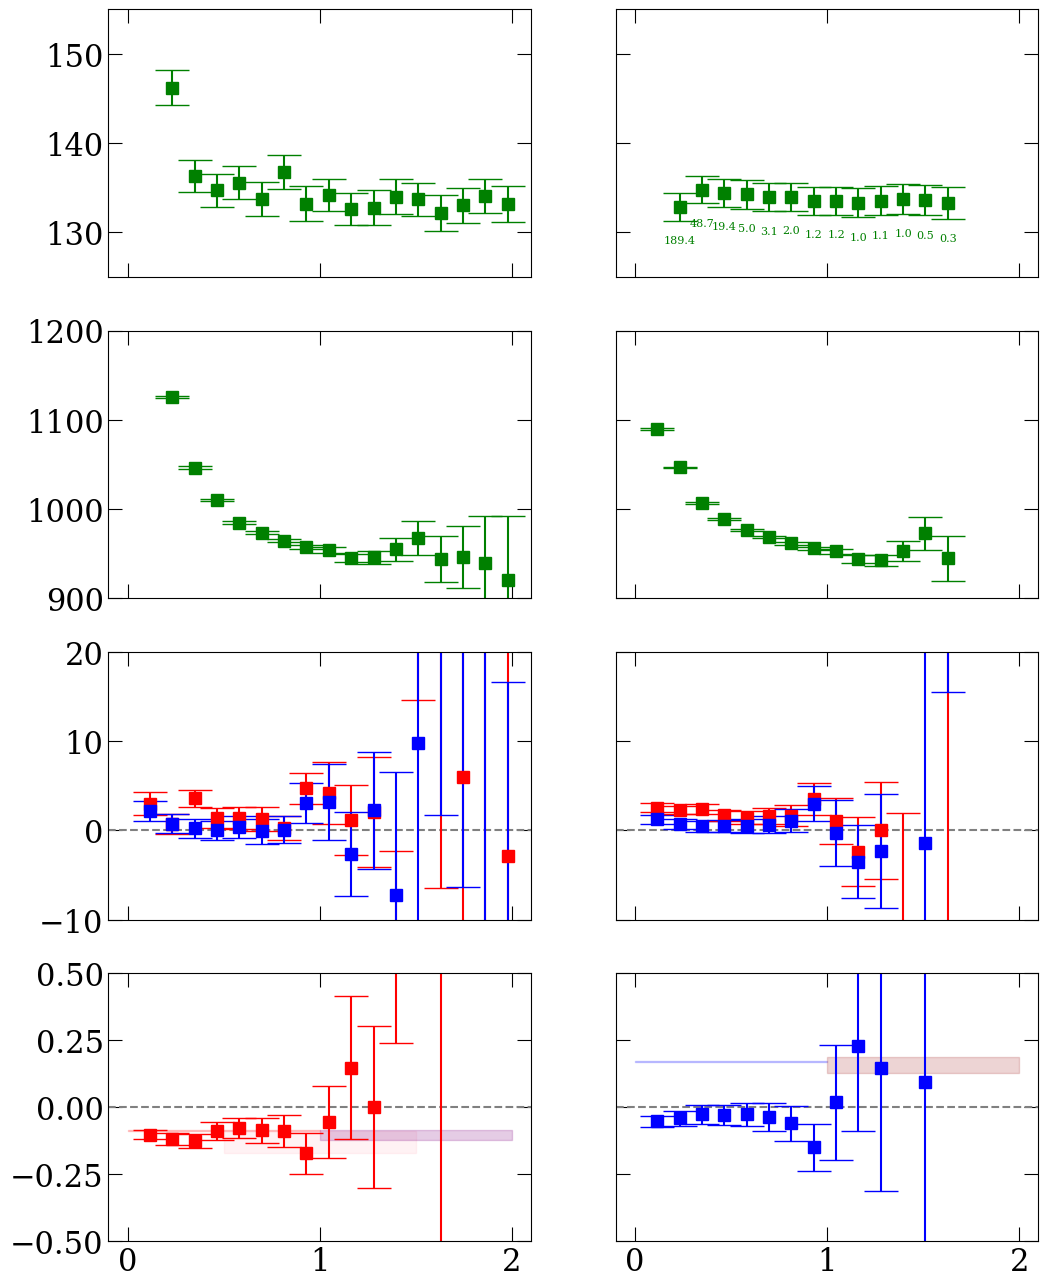

In [81]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

tau=1
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

func=lambda c:np.log(c/np.roll(c,-1))
meff_Npi=yu.jackmap(func,c_Npi)
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)
meffp_32shift=meff_32-meff_pi-meff_N
meffp_12shift=meff_12-meff_pi-meff_N

def contaminate(dat):
    error=1/lat_aInv * 1
    shape=dat.shape
    t=yu.jackknife(np.random.randn(*shape)*error*np.sqrt(shape[0]))
    return dat+t

meff_pion=contaminate(meff_pion)
meff_N=contaminate(meff_N)
meffp_32shift=contaminate(meffp_32shift)
meffp_12shift=contaminate(meffp_12shift)


fitmax=18

fig, axs = yu.getFigAxs(4,2,Lrow=4,Lcol=6, sharex='col', sharey='row')
ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1; tmax=fitmax
ax.set_ylim([125,155])
# ax.axhline(135,color='grey',ls='--',marker='')
# axs[0,1].axhline(135,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_pion)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[1,0]
ax.set_ylim([900,1200])
# ax.axhline(938,color='grey',ls='--',marker='')
# axs[1,1].axhline(938,color='grey',ls='--',marker='')

mean,err=yu.jackme(meff_N)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[2,0]
ax.set_ylim([-10,20])
ax.axhline(0,color='grey',ls='--',marker='')
axs[2,1].axhline(0,color='grey',ls='--',marker='')

mean,err=yu.jackme(meffp_32shift)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(meffp_12shift)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[3,0]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0.5,1.5]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)


ax=axs[3,1]
ax.set_ylim([-0.5,0.5])
ax.axhline(0,color='grey',ls='--',marker='')

plt_x=np.array([0,1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,2]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


func_Cpi=lambda t,cpi,mpi: cpi*(np.exp(-mpi*t) + np.exp(-mpi*(lat_NT-t)))
func_CN=lambda t,cN,mN: cN*np.exp(-mN*t)
func_CNpi=lambda t,cNpi,ENpi,cpi_N,mpi,mN: cNpi*np.exp(-ENpi*t)+cpi_N*np.exp(-mpi*(lat_NT-t))*np.exp(-mN*t)

func_ratio=lambda t,mpi,mN,dE,r: func_CNpi(t,1,dE+mpi+mN,r,mpi,mN)/(func_Cpi(t,1,mpi)*func_CN(t,1,mN))
func_rlogr=lambda t,mpi,mN,dE,r: np.log(func_ratio(t,mpi,mN,dE,r)/func_ratio(t+1,mpi,mN,dE,r))

pars0=[140/lat_aInv,1000/lat_aInv,10/lat_aInv,-5/lat_aInv]
fitmins=range(1,fitmax-3)
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    y_jk=np.concatenate([meff_pion[:,fitmin:fitmax],meff_N[:,fitmin:fitmax],meffp_32shift[:,fitmin:fitmax],meffp_12shift[:,fitmin:fitmax]],axis=1)
    def fitfunc(pars):
        mpi,mN,dE32,dE12=pars
        t=[mpi]*len(tList)+[mN]*len(tList)+list(func_rlogr(tList,mpi,mN,dE32,1))+list(func_rlogr(tList,mpi,mN,dE12,1))
        return t
    
    sizes=[len(tList)]*(len(y_jk[0])//len(tList))
    sizeTotal=len(y_jk[0])
    mask=np.zeros([sizeTotal,sizeTotal])
    ind=0
    for i in range(4):
        mask[ind:ind+sizes[i],ind:ind+sizes[i]]+=1
        ind+=sizes[i]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
    # pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
    
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    
    # break

for fit in fits:
    fitmin,pars_jk,chi2_jk,Ndof=fit
    mean,err=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof

    ax=axs[0,1]
    plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='g')
    ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12; chi2Size=8
    ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_yerr-chi2_shift),color='g',size=chi2Size,ha='center') 
    
    ax=axs[1,1]
    plt_x=fitmin*xunit; plt_y=mean[1]*yunit; plt_yerr=err[1]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='g')
    
    ax=axs[2,1]
    plt_x=fitmin*xunit; plt_y=mean[2]*yunit; plt_yerr=err[2]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='r')
    plt_x=fitmin*xunit; plt_y=mean[3]*yunit; plt_yerr=err[3]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='b')
    
    
    mpias_jk=np.array([[es2sl(1/(1/mpi+1/mN),lat_NL,dE32)*mpi,es2sl(1/(1/mpi+1/mN),lat_NL,dE12)*mpi] for mpi,mN,dE32,dE12 in pars_jk])
    mean,err=yu.jackme(mpias_jk)
    
    ax=axs[3,0]
    plt_x=fitmin*xunit; plt_y=mean[0]*1; plt_yerr=err[0]*1
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='r')
    
    ax=axs[3,1]
    plt_x=fitmin*xunit; plt_y=mean[1]*1; plt_yerr=err[1]*1
    ax.errorbar(plt_x,plt_y,plt_yerr,fmt='s',color='b')
    
    # break

# below are old tests

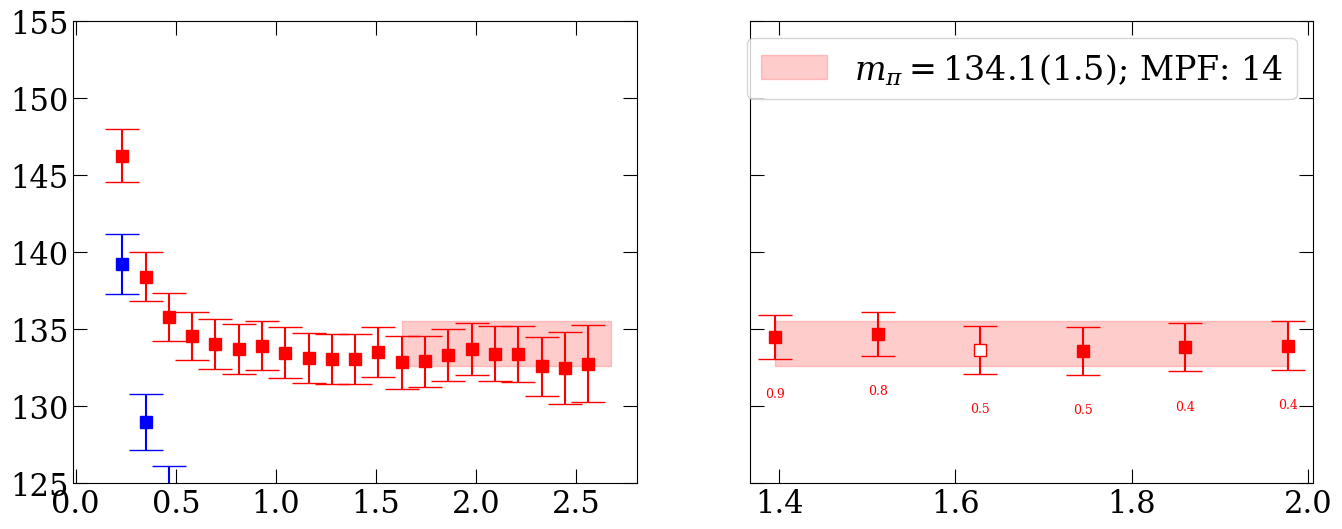

In [3]:
tau=1
func=lambda c:np.log(c/np.roll(c,-1))
meff_pion_nobwd=yu.jackmap(func,np.real(data['P']))
def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))

# error=1/lat_aInv * 1
# shape=meff_pion.shape
# t=yu.jackknife(np.random.randn(*shape)*error)
# meff_pion+=t

fitmax_pion=24-tau
fitmins_pion=range(12,fitmax_pion-5)

m_pi=None
for mask in [None,'uncorrelated'][:1]:
    pars0=[0.08]
    fits=[]
    for fitmin in fitmins_pion:
        tList=np.arange(fitmin,fitmax_pion)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff_pion[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=mask)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
        if mask is None and fitmin==20:
            mean,err,cov=yu.jackmec(y_jk)
            covI=np.linalg.inv(cov)
            eval,evect=np.linalg.eig(cov)
            one=np.zeros(len(cov))+1
            weights=np.linalg.inv(cov)@one
            weights=weights/np.sum(weights)
            
    fits_pion=fits

    fig, axs = yu.getFigAxs(1,2,Lrow=6,Lcol=8,sharey=True)
    chi2Size=9
    fig.suptitle(mask)

    ax=axs[0,0]
    xunit=lat_a; yunit=lat_aInv
    tmin=1; tmax=fitmax_pion
    ax.set_ylim([125,155])
    # ax.axhline(135,color='grey',ls='--')

    mean,err=yu.jackme(meff_pion)
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='r')
    
    mean,err=yu.jackme(meff_pion_nobwd)
    plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

    pars_jk,props_jk=yu.jackMA(fits)
    # if mask!='uncorrelated':
    m_pi=pars_jk[:,0]
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],23])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}')    
    # ax.legend(fontsize=16)

    ax=axs[0,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2, label=r'$m_\pi=$'+yu.un2str(plt_y,plt_yerr) + f'; MPF: {fits_pion[ind_mpf][0]}') 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color='r',mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color='r',size=chi2Size,ha='center') 
    ax.legend()
    
    plt.savefig('fig/c2pt_pion_correlated_new.pdf' if mask is None else 'fig/c2pt_pion_uncorrelated_new.pdf')

<ErrorbarContainer object of 3 artists>

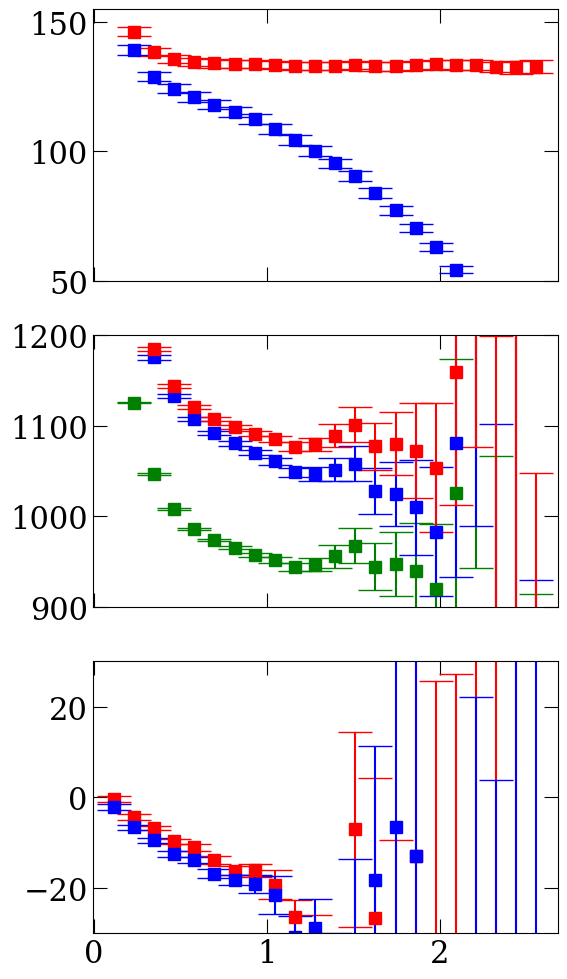

In [10]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

func=lambda c:np.log(c/np.roll(c,-1))
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_Npi=yu.jackmap(func,c_Npi)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)

def C2pt2meff(C2pt,totalT):
    tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
    t=C2pt # dim=time
    t=(np.roll(t,-tau,axis=0))/(t)
    t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
    return t
func=lambda c2pt:C2pt2meff(c2pt,48)
meff_pion=yu.jackmap(func,np.real(data['P']))


fig, axs = yu.getFigAxs(3,1,Lrow=4,Lcol=6, sharex=True)
ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1; tmax=fitmax_pion
ax.set_ylim([50,155])
# ax.axhline(135,color='grey',ls='--')

mean,err=yu.jackme(meff_pion)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(meff_pi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

ax=axs[1,0]
xunit=lat_a; yunit=lat_aInv
ax.set_ylim([900,1200])

mean,err=yu.jackme(meff_N)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(meff_Npi)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

mean,err=yu.jackme(meff_N+meff_pion)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

# mean,err=yu.jackme(meff_32)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='orange')


ax=axs[2,0]
xunit=lat_a; yunit=lat_aInv
ax.set_ylim([-30,30])

mean,err=yu.jackme(meff_32-meff_N-meff_pion)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(meff_12-meff_N-meff_pion)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

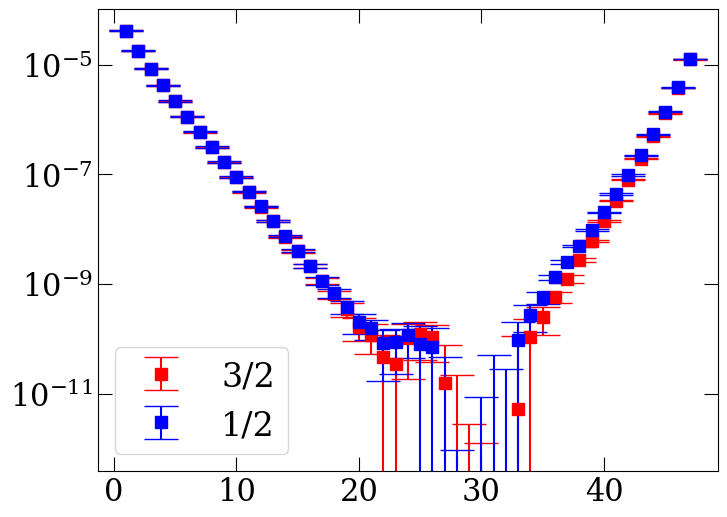

In [44]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])


fig, axs = yu.getFigAxs(1,1,Lrow=6,Lcol=8, sharex=True)
ax=axs[0,0]
xunit=1; yunit=1
tmin=1; tmax=48

# mean,err=yu.jackme(c_N)
# plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
# ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

mean,err=yu.jackme(c_32)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r',label='3/2')

mean,err=yu.jackme(c_12)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b',label='1/2')

ax.set_yscale('log')
ax.legend()

In [57]:
# mN=938
# E12=1070

# [np.exp(-E12*t/lat_aInv+mN*(48-t)/lat_aInv) for t in [10,15,20,22]]

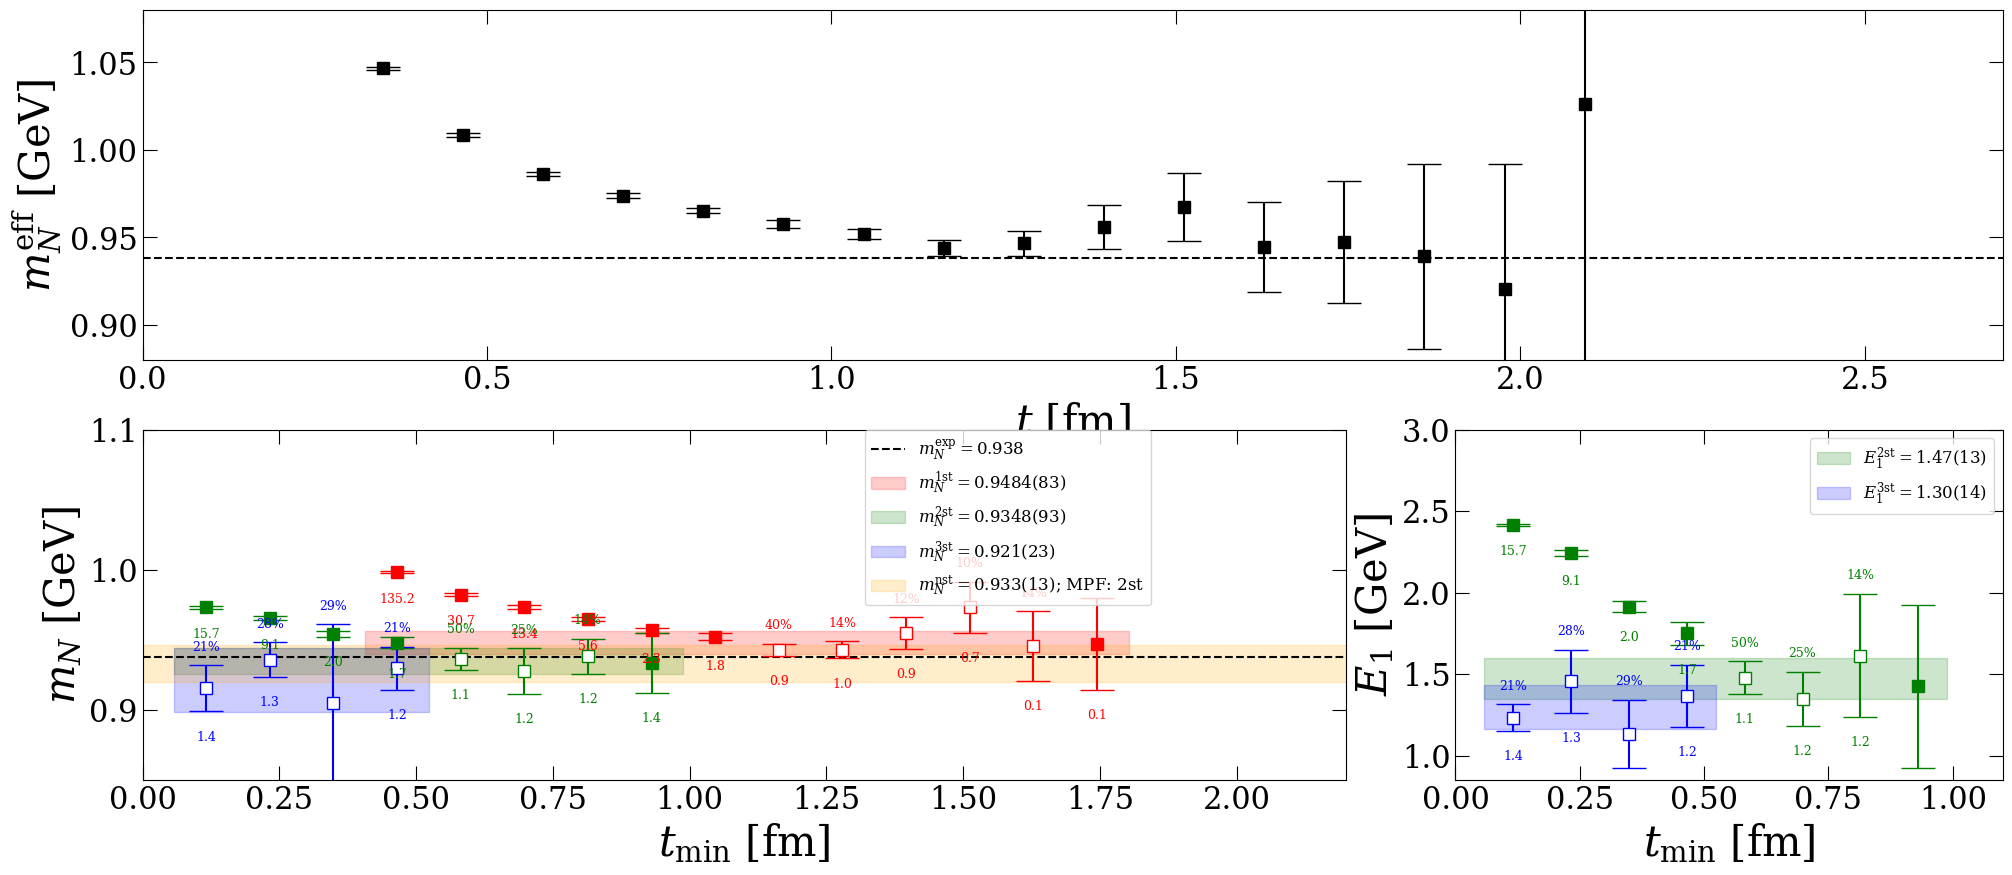

In [4]:
settings={
    'fitmins_1st':range(4,15+1),
    'fitmins_2st':range(1,8+1),
    'fitmins_3st':range(1,4+1),
    'ylim1':[0.6,1.7],
    'ylim1':[0.88,1.08],
    'ylim2':[0.85,1.1],
    'ylim3':[0.85,3.0],
    'xlim1':[0,2.7],
    'xlim2':[0,2.2],
    'xlim3':[0,1.1],
}

propThreshold=0.1

func=lambda c:np.log(c/np.roll(c,-1))
meff_N=yu.jackmap(func,np.real(data['N']))

func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

xUnit=lat_a; yUnit=lat_aInv/1000; xunit=xUnit; yunit=yUnit
fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
(ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])

ax1.set_xlabel(r'$t$ [fm]')
ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
ax2.set_ylabel(r'$m_N$ [GeV]')
ax3.set_ylabel(r'$E_1$ [GeV]')
ax1.set_ylim(settings['ylim1'])
ax2.set_ylim(settings['ylim2'])
ax3.set_ylim(settings['ylim3'])
ax1.set_xlim(settings['xlim1'])
ax2.set_xlim(settings['xlim2'])
ax3.set_xlim(settings['xlim3'])

mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)

mEff_jk=meff_N
(mEff_mean,mEff_err)=yu.jackme(mEff_jk)
mEff_rela=np.abs(mEff_err/mEff_mean)
temp=[(i,rela) for i,rela in enumerate(mEff_rela) if rela>0.2 and i!=0]
fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1

tmin=1; tmax=fitmax+1
plt_x=np.arange(tmin,tmax)*xUnit; plt_y=mEff_mean[tmin:tmax]*yUnit; plt_err=mEff_err[tmin:tmax]*yUnit
ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

meffQ=True; corrQ=True; C2pt_jk=None

pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
DNpar=1 if meffQ else 0

fits_all=[]
# 1st fits
color='r'
fitmins=settings['fitmins_1st']
pars0=pars0_initial[:2-DNpar]
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_1st(tList,*pars)
        return func_C2pt_1st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    
pars_jk,props_jk=yu.jackMA(fits)
m_N1st=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
# for i,prop in enumerate(np.mean(props_jk,axis=0)):
#     if prop<0.1:
#         continue
#     fitmin,t_pars_jk,chi2_jk,Ndof=fits[i]
#     print(i,prop,fitmin*xUnit,np.mean(t_pars_jk,axis=0)[0]*yUnit,np.mean(chi2_jk)/Ndof,np.mean(chi2_jk),Ndof)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_mean,pars_err=yu.jackme(pars_jk)
pars0=pars_mean
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# 2st fits
color='g'
fitmins=settings['fitmins_2st']
pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_2st(tList,*pars)
        return func_C2pt_2st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
pars_jk,props_jk=yu.jackMA(fits)
m_N2st=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
pars0=yu.jackme(pars_jk)[0]
res=pars_jk.copy()
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
pars_mean,pars_err=yu.jackme(pars_jk)
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    plt_x=fitmin*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
    ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
# 3st fits  
color='b'
fitmins=settings['fitmins_3st']
pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
fits=[]
for fitmin in fitmins:
    tList=np.arange(fitmin,fitmax)
    def fitfunc(pars):
        if meffQ:
            return func_mEff_3st(tList,*pars)
        return func_C2pt_3st(tList,*pars)
    y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
    pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
    pars0=np.mean(pars_jk,axis=0)
    fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
pars_jk,props_jk=yu.jackMA(fits)
m_Nst=pars_jk[:,0]
props_mean=np.mean(props_jk,axis=0)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
pars0=yu.jackme(pars_jk)[0]
# print(pars0)
pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
pars_mean,pars_err=yu.jackme(pars_jk)
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
for i,fit in enumerate(fits):
    fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    (pars_mean,pars_err)=yu.jackme(pars_jk)
    chi2R=np.mean(chi2_jk)/Ndof
    showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
    
    plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
    if propThreshold is not None and prop>propThreshold:
        ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
    
    plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
    ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
    ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
    if propThreshold is not None and prop>propThreshold:
        ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        
color='orange'
pars_jk,props_jk=yu.jackMA(fits_all)
ind_mpf=np.argmax(np.mean(props_jk,axis=0))
pars_mean,pars_err=yu.jackme(pars_jk)
plt_x=settings['xlim2']; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    

ax2.legend(loc=(0.6,0.5),fontsize=12)
ax3.legend(fontsize=12)
plt.savefig(f'fig/c2pt_nucleon_Nsrc={Nsrc}.pdf')

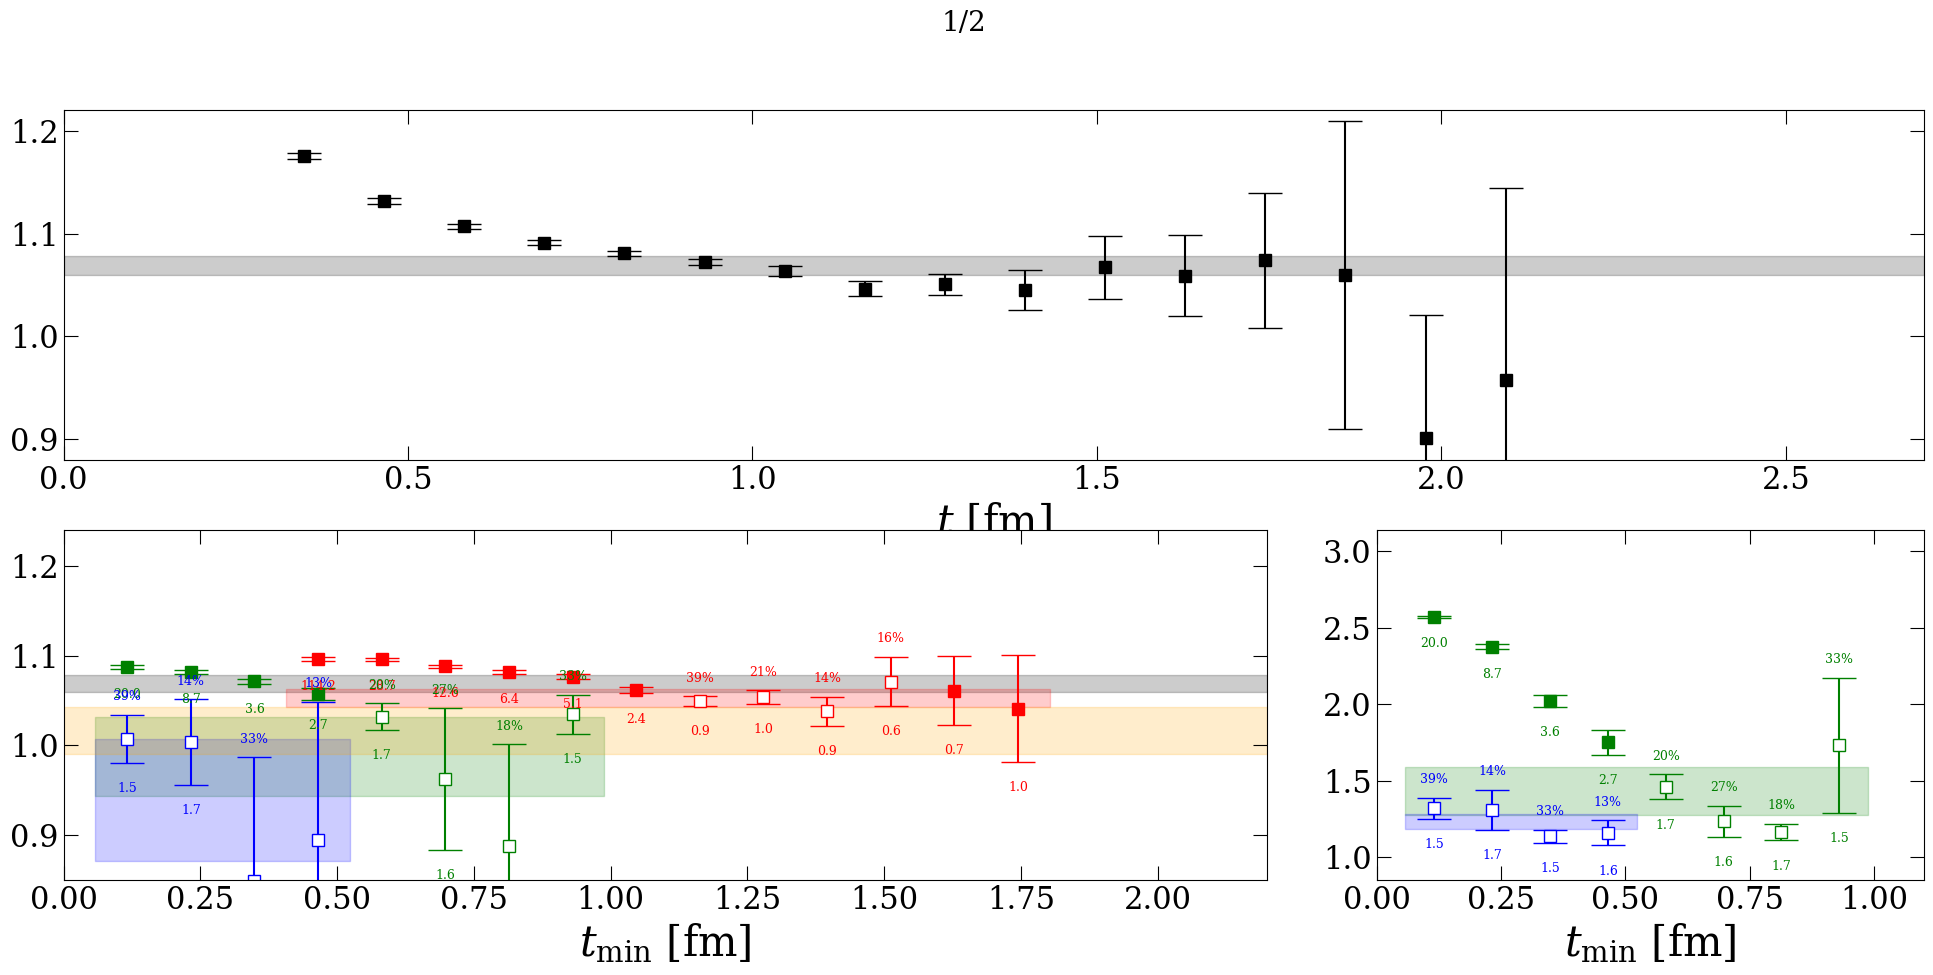

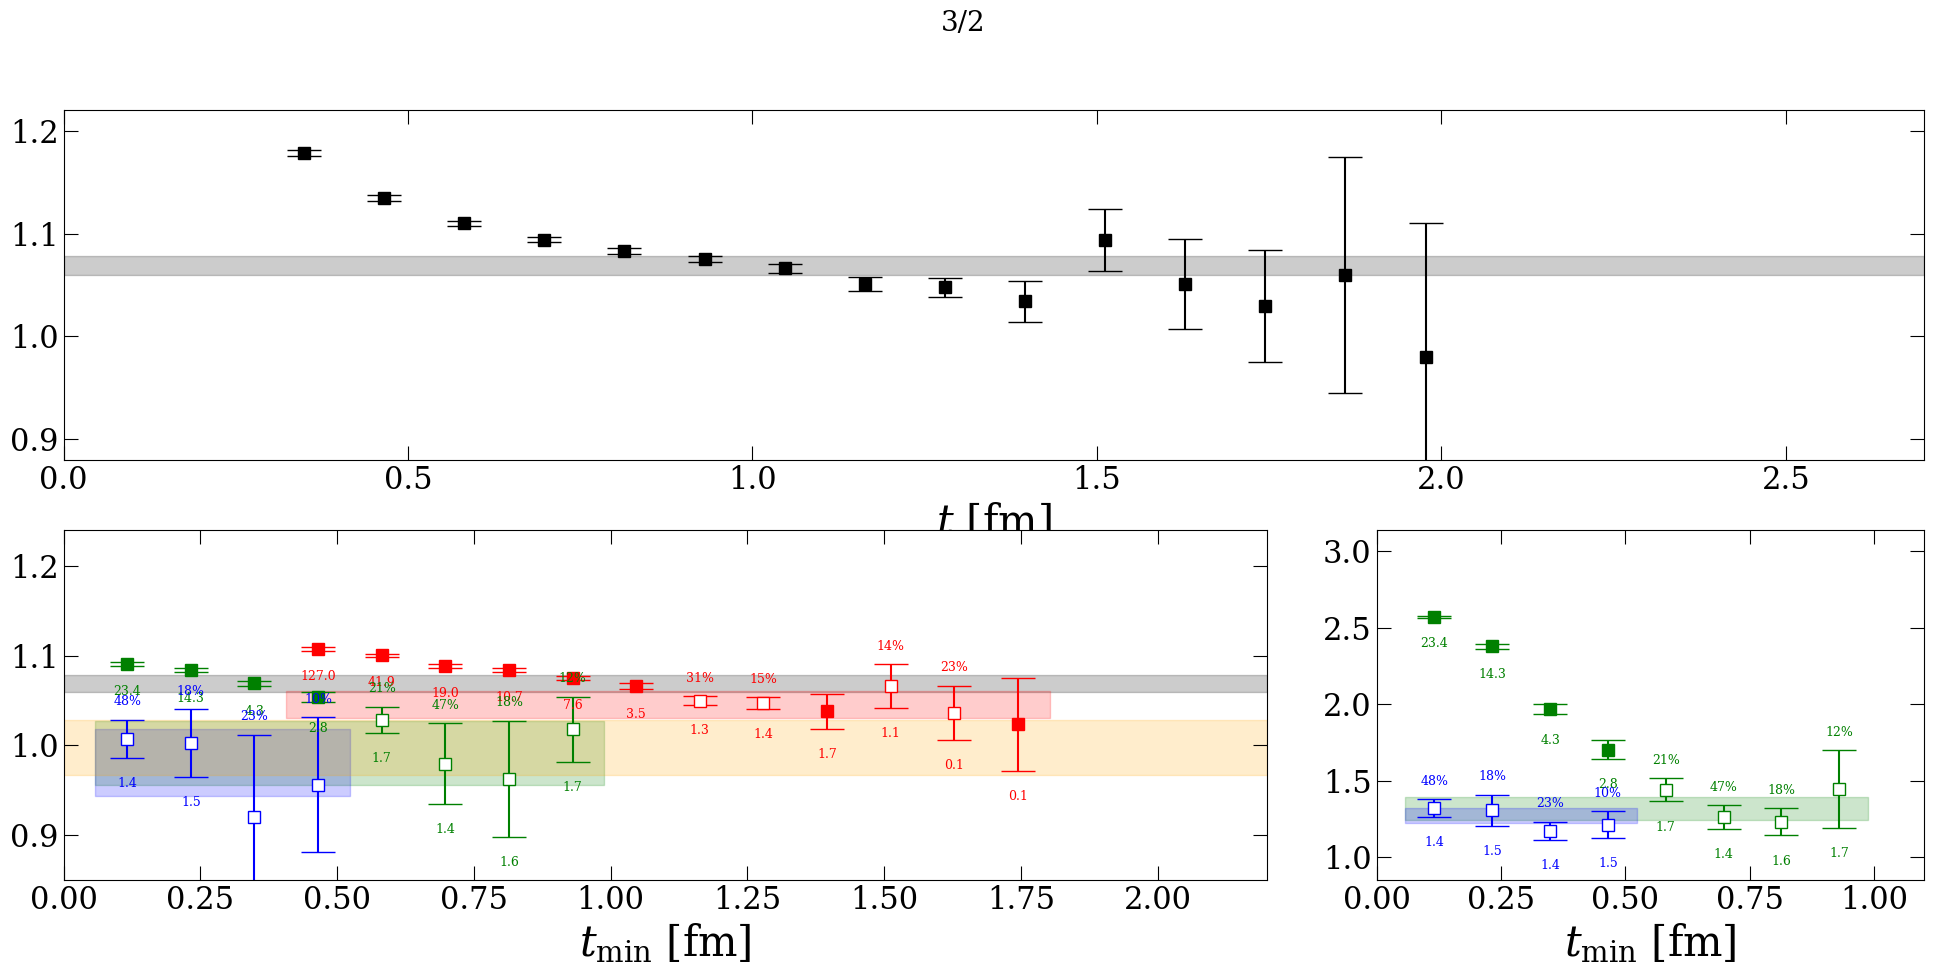

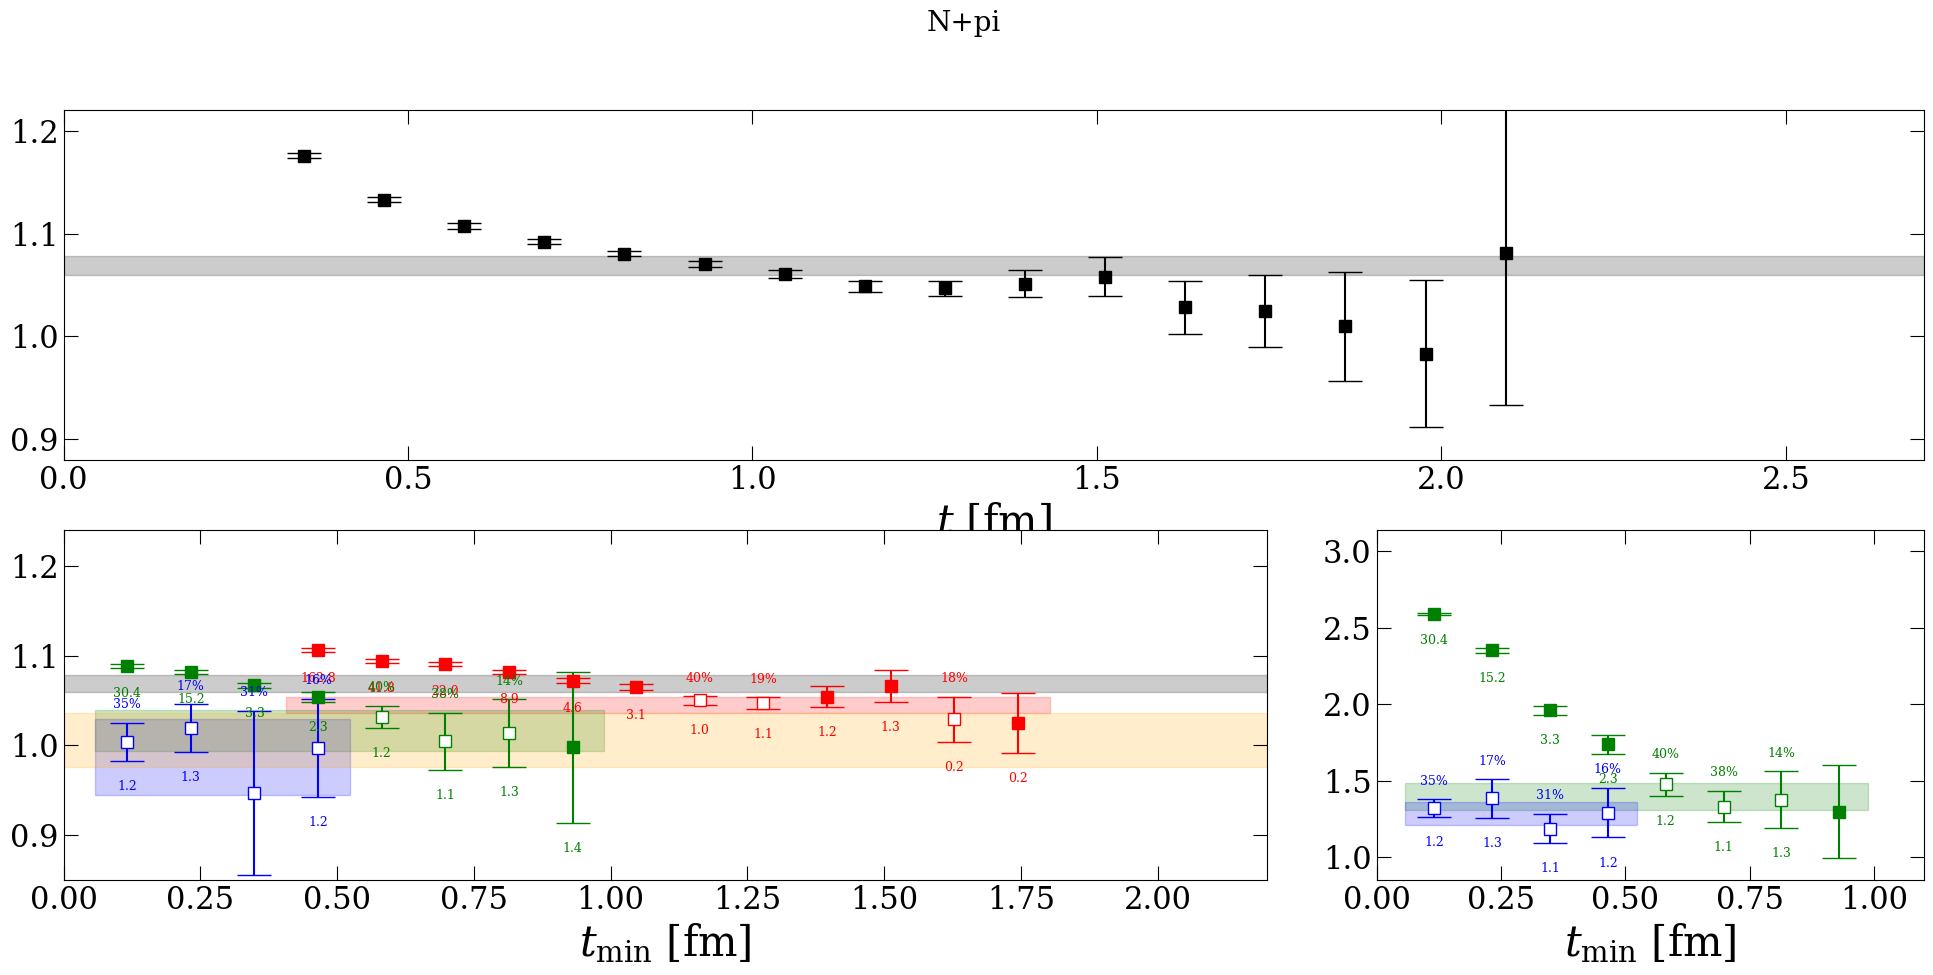

In [31]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

shift=0.14
settings={
    'fitmins_1st':range(4,15+1),
    'fitmins_2st':range(1,8+1),
    'fitmins_3st':range(1,4+1),
    'ylim1':[0.6,1.7+shift],
    'ylim1':[0.88,1.08+shift],
    'ylim2':[0.85,1.1+shift],
    'ylim3':[0.85,3.0+shift],
    'xlim1':[0,2.7],
    'xlim2':[0,2.2],
    'xlim3':[0,1.1],
}

propThreshold=0.1

for i_cx2,c_x2 in enumerate([c_12,c_32,c_Npi]):
    func=lambda c:np.log(c/np.roll(c,-1))
    meff_N=yu.jackmap(func,np.real(c_x2))

    func_C2pt_1st=lambda t,E0,c0: c0*np.exp(-E0*t)
    func_C2pt_2st=lambda t,E0,c0,dE1,rc1: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t))
    func_C2pt_3st=lambda t,E0,c0,dE1,rc1,dE2,rc2: c0*np.exp(-E0*t)*(1 + rc1*np.exp(-dE1*t) + rc2*np.exp(-dE2*t))
    func_mEff_1st=lambda t,E0: np.log(func_C2pt_1st(t,E0,1)/func_C2pt_1st(t+1,E0,1))
    func_mEff_2st=lambda t,E0,dE1,rc1: np.log(func_C2pt_2st(t,E0,1,dE1,rc1)/func_C2pt_2st(t+1,E0,1,dE1,rc1))
    func_mEff_3st=lambda t,E0,dE1,rc1,dE2,rc2: np.log(func_C2pt_3st(t,E0,1,dE1,rc1,dE2,rc2)/func_C2pt_3st(t+1,E0,1,dE1,rc1,dE2,rc2))

    xUnit=lat_a; yUnit=lat_aInv/1000; xunit=xUnit; yunit=yUnit
    fig, axd = plt.subplot_mosaic([['f1','f1','f1'],['f2','f2','f3']],figsize=(24,10))
    fig.suptitle(['1/2','3/2','N+pi'][i_cx2])
    (ax1,ax2,ax3)=(axd[key] for key in ['f1','f2','f3'])

    ax1.set_xlabel(r'$t$ [fm]')
    ax2.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    ax3.set_xlabel(r'$t_{\mathrm{min}}$ [fm]')
    # ax1.set_ylabel(r'$m_N^{\mathrm{eff}}$ [GeV]')
    # ax2.set_ylabel(r'$m_N$ [GeV]')
    # ax3.set_ylabel(r'$E_1$ [GeV]')
    ax1.set_ylim(settings['ylim1'])
    ax2.set_ylim(settings['ylim2'])
    ax3.set_ylim(settings['ylim3'])
    ax1.set_xlim(settings['xlim1'])
    ax2.set_xlim(settings['xlim2'])
    ax3.set_xlim(settings['xlim3'])

    # mN_exp=0.938; mp_exp,mn_exp=(0.93827,0.93957)
    # ax1.axhline(y=mN_exp,color='black',linestyle = '--', marker='')
    # ax2.axhline(y=mN_exp,color='black',linestyle = '--', marker='', label=r'$m_N^{\mathrm{exp}}=$'+'%0.3f'%mN_exp)

    mean,err=yu.jackme(m_pi+m_N2st)
    plt_x=np.array(settings['xlim1']); plt_y=mean*yUnit; plt_err=err*yUnit
    ax1.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='black',alpha=0.2)
    plt_x=np.array(settings['xlim2'])
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color='black',alpha=0.2, label=r'$m_{N(2st)}+m_{\pi}=$'+yu.un2str(plt_y,plt_err))


    mEff_jk=meff_N
    (mEff_mean,mEff_err)=yu.jackme(mEff_jk)
    mEff_rela=np.abs(mEff_err/mEff_mean)
    temp=[(i,rela) for i,rela in enumerate(mEff_rela) if rela>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1

    tmin=1; tmax=fitmax+1
    plt_x=np.arange(tmin,tmax)*xUnit; plt_y=mEff_mean[tmin:tmax]*yUnit; plt_err=mEff_err[tmin:tmax]*yUnit
    ax1.errorbar(plt_x,plt_y,plt_err,color='black',fmt='s')

    meffQ=True; corrQ=True; C2pt_jk=None

    pars0_initial=[0.4,0.5,2,0.8,1] if meffQ else [0.4,1e-8,0.5,2,0.8,1]
    DNpar=1 if meffQ else 0

    fits_all=[]
    # 1st fits
    color='r'
    fitmins=settings['fitmins_1st']
    pars0=pars0_initial[:2-DNpar]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_1st(tList,*pars)
            return func_C2pt_1st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('1st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    m_N=pars_jk[:,0]
    props_mean=np.mean(props_jk,axis=0)
    # for i,prop in enumerate(np.mean(props_jk,axis=0)):
    #     if prop<0.1:
    #         continue
    #     fitmin,t_pars_jk,chi2_jk,Ndof=fits[i]
    #     print(i,prop,fitmin*xUnit,np.mean(t_pars_jk,axis=0)[0]*yUnit,np.mean(chi2_jk)/Ndof,np.mean(chi2_jk),Ndof)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_mean,pars_err=yu.jackme(pars_jk)
    pars0=pars_mean
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2,label=r'$m_N^{\mathrm{1st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 2st fits
    color='g'
    fitmins=settings['fitmins_2st']
    pars0=np.hstack([pars0,pars0_initial[2-DNpar:4-DNpar]])
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_2st(tList,*pars)
            return func_C2pt_2st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('2st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    pars0=yu.jackme(pars_jk)[0]
    res=pars_jk.copy()
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{2st}}=$'+yu.un2str(plt_y,plt_err))
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xUnit; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xUnit; plt_y=pars_mean[1]*yUnit; plt_err=pars_err[1]*yUnit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
    # 3st fits  
    color='b'
    fitmins=settings['fitmins_3st']
    pars0=np.hstack([pars0,pars0_initial[4-DNpar:6-DNpar]])
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            if meffQ:
                return func_mEff_3st(tList,*pars)
            return func_C2pt_3st(tList,*pars)
        y_jk=mEff_jk[:,tList] if meffQ else C2pt_jk[:,tList]
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0,mask=None if corrQ else 'uncorrelated')
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        fits_all.append([('3st',fitmin),pars_jk[:,:1],chi2_jk,Ndof])
    pars_jk,props_jk=yu.jackMA(fits)
    props_mean=np.mean(props_jk,axis=0)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))    
    pars0=yu.jackme(pars_jk)[0]
    # print(pars0)
    pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))
    plt_x=np.array([fitmins[0]-0.5,fitmins[-1]+0.5])*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
    ax3.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$E_1^{\mathrm{3st}}=$'+yu.un2str(plt_y,plt_err))    
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit; prop=props_mean[i]
        pars_jk[:,1]=pars_jk[:,0]+pars_jk[:,2-DNpar]
        (pars_mean,pars_err)=yu.jackme(pars_jk)
        chi2R=np.mean(chi2_jk)/Ndof
        showQ = i==ind_mpf if propThreshold is None else prop>propThreshold
        
        plt_x=fitmin*xunit; plt_y=pars_mean[0]*yunit; plt_err=pars_err[0]*yunit
        ax2.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax2.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax2.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center')
        if propThreshold is not None and prop>propThreshold:
            ax2.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
        
        plt_x=fitmin*xunit; plt_y=pars_mean[1]*yunit; plt_err=pars_err[1]*yunit
        ax3.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if showQ else None)
        ylim=ax3.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax3.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        if propThreshold is not None and prop>propThreshold:
            ax3.annotate(f"{int(prop*100)}%",(plt_x,plt_y+plt_err+chi2_shift*0.5),color=color,size=chi2Size,ha='center')
            
            
    color='orange'
    pars_jk,props_jk=yu.jackMA(fits_all)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    pars_mean,pars_err=yu.jackme(pars_jk)
    plt_x=settings['xlim2']; plt_y=pars_mean[0]*yUnit; plt_err=pars_err[0]*yUnit
    ax2.fill_between(plt_x,plt_y-plt_err,plt_y+plt_err,color=color,alpha=0.2, label=r'$m_N^{\mathrm{nst}}=$'+yu.un2str(plt_y,plt_err) + f'; MPF: {fits_all[ind_mpf][0][0]}')    

    # ax2.legend(loc=(0.6,0.5),fontsize=12)
    # ax3.legend(fontsize=12)
    # plt.savefig(f'fig/c2pt_nucleon_Nsrc={Nsrc}.pdf')

In [6]:
# sigma term to lattice scattering length 1/2 # Hoferichter:2016ocj
mpiC_phys=139.57
sgm_center=59.1
a12_center=169.8*1e-3 * (mpiC_phys**-1); a12_error=2.0*1e-3 * (mpiC_phys**-1)
a32_center=-86.3*1e-3 * (mpiC_phys**-1); a32_error=1.8*1e-3 * (mpiC_phys**-1)
a12_center_pheLat=178.8*1e-3 * (mpiC_phys**-1); a12_error_pheLat=3.8*1e-3 * (mpiC_phys**-1)
a32_center_pheLat=-77.5*1e-3 * (mpiC_phys**-1); a32_error_pheLat=3.5*1e-3 * (mpiC_phys**-1)

def a2sgm(a12,a32):
    c12=0.242*1e3*mpiC_phys
    c32=0.874*1e3*mpiC_phys
    return sgm_center + c12*(a12-a12_center) + c32*(a32-a32_center)

def sgm2a12(sgm):    
    c12=0.242*1e3*mpiC_phys
    c32=0.874*1e3*mpiC_phys
    return a12_center + (sgm-sgm_center)/c12

# scattering length <-> energy shift
def sl2es(mu, L, a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(mu, L, dE):
    return yu.fsolve2(lambda a0:sl2es(mu, L, a0)-dE, 0)

mN=931; mpi=131
mu=1/(1/mN+1/mpi); L=4.5 * hbarc

# print(f'1/2: {sl2es(mu,L,a12_center)}, 3/2: {sl2es(mu,L,a32_center)}')

# for sgm in [40,60]:
#     print(f'{sgm}: {sl2es(mu,L,sgm2a12(sgm))}')
    
es2sl(mu,L,-5),a12_center

# a2sgm(0.169*mpiC_phys**-1/2,-0.1*mpiC_phys**-1)

a2sgm(0.123*(mpiC_phys**-1),-0.098*(mpiC_phys**-1))

mN=938/lat_aInv
mpi=140/lat_aInv
mu=1/(1/mN+1/mpi) 
L=48

# def sl2es(a0):
#     c1=-2.837297; c2=6.375183
#     return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
# def es2sl(dE):
#     return yu.fsolve2(lambda a0:sl2es(a0)-dE, 0)


a12_center=169.8*1e-3 * (mpiC_phys**-1); a12_error=2.0*1e-3 * (mpiC_phys**-1)
a32_center=-86.3*1e-3 * (mpiC_phys**-1); a32_error=1.8*1e-3 * (mpiC_phys**-1)



# scattering length <-> energy shift
def sl2es(mu, L, a0):
    c1=-2.837297; c2=6.375183
    return - (2*np.pi)/(mu*L) * a0/L * ( 1 + c1*a0/L + c2*(a0/L)**2 ) / L
def es2sl(mu, L, dE):
    res=yu.fsolve2(lambda a0:sl2es(mu, L, a0)-dE, 0)
    # print(res)
    return res

m_mu=[1/(1/mpi+1/mN) for mpi,mN in zip(m_pi,m_N)] # lat unit

a32mpi_phy=(-86.3*1e-3,1.8*1e-3); a12mpi_phy=(169.8*1e-3,2.0*1e-3)
# a32mpi_phy=(-77.5*1e-3,3.5*1e-3); a12mpi_phy=(178.8*1e-3,3.8*1e-3)

a32mpi_pol=(-0.128,0.015); a12mpi_pol=(0.093,0.025)
a32mpi_delta=(-0.13,0.04)

# print(a2sgm(a12mpi_phy[0]/mpiC_phys,a32mpi_phy[0]/mpiC_phys))
# print(a2sgm(a12mpi_pol[0]/mpiC_phys,a32mpi_pol[0]/mpiC_phys))


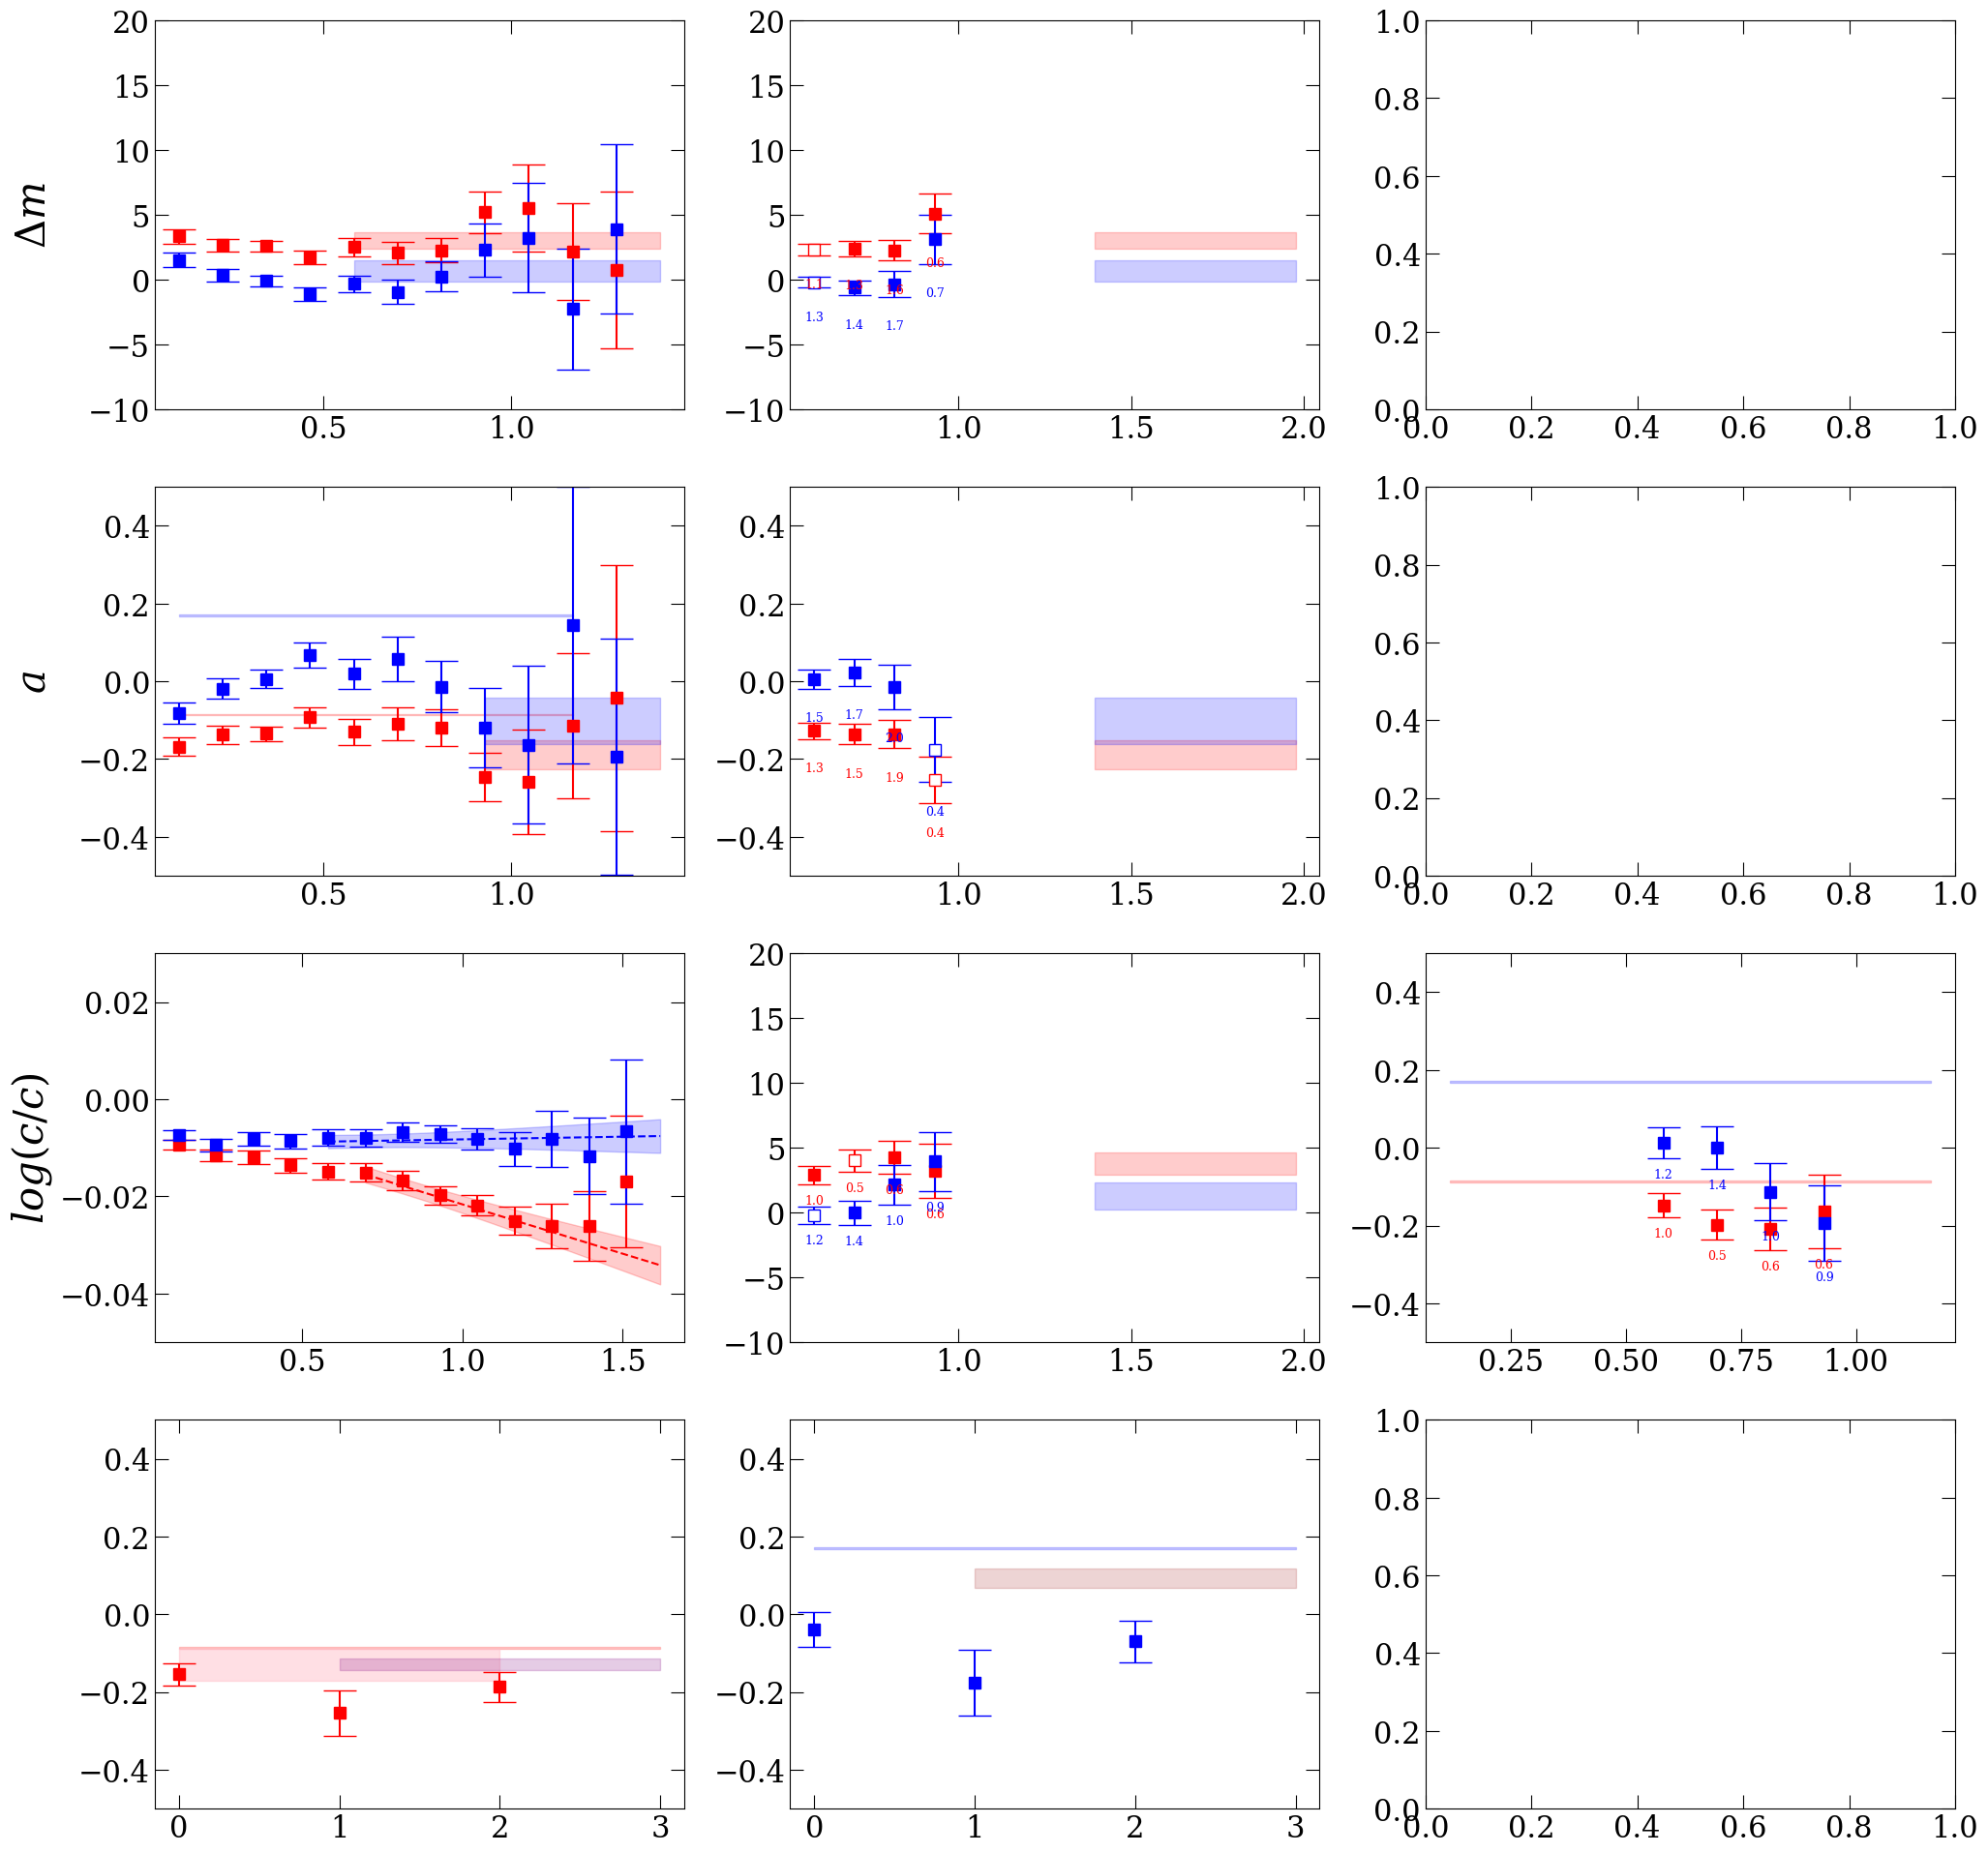

In [8]:
coeffs_32=[[[1,'B232'],[-1,'B122']],[[1,'W1222'],[-1,'W1321'],[1,'W1322'],[-1,'W2321']],[[-1,'Z114'],[1,'Z132'],[-1,'Z214'],[-1,'Z222']]]
coeffs_12=[[[-3/2,'B114'],[1/2,'B122'],[3/2,'B132'],[-3/2,'B214'],[1,'B232']],
           [[-3/2,'W1141'],[3/2,'W1142'],[3/2,'W1221'],[-1/2,'W1222'],[1/2,'W1321'],[-1/2,'W1322'],[-1,'W2321']],
           [[1/2,'Z114'],[-3/2,'Z122'],[-1/2,'Z132'],[1/2,'Z214'],[-1,'Z222']]
]
method=['2','2','1']

Nstoc=12

c_12=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_12,method) for cont in conts],axis=0))
c_32=np.real(data['M'][:,:,0]+np.sum([
    np.mean(cont[0]*data[f'{cont[1]}_{method}'][:,:,:] if cont[1][0] in [] else cont[0]*data[f'{cont[1]}_{method}'][:,:,:Nstoc],axis=-1)
    for conts,method in zip(coeffs_32,method) for cont in conts],axis=0))
c_Npi=np.real(data['N']*data['P'])
c_N=np.real(data['N'])
c_pi=np.real(data['P'])

mean,err=yu.jackme(c_32)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.1 and i!=0]
fitmax32=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
mean,err=yu.jackme(c_12)
rela=np.abs(err/mean)
temp=[(i,r) for i,r in enumerate(rela) if r>0.1 and i!=0]
fitmax12=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
fitmaxs=[fitmax32,fitmax12]
fitmaxs=[12,12]
# print(fitmaxs)
dfitminmax=3
fitmins=range(5,np.min(fitmaxs)-dfitminmax)

func=lambda c:np.log(c/np.roll(c,-1))
meff_12=yu.jackmap(func,c_12)
meff_32=yu.jackmap(func,c_32)
meff_Npi=yu.jackmap(func,c_Npi)
meff_N=yu.jackmap(func,c_N)
meff_pi=yu.jackmap(func,c_pi)

a_32_mpi=np.array([[es2sl(mu,lat_NL,dE)*mpi for dE in dEs] for dEs,mu,mpi in zip(meff_32-meff_Npi,m_mu,m_pi)])
a_12_mpi=np.array([[es2sl(mu,lat_NL,dE)*mpi for dE in dEs] for dEs,mu,mpi in zip(meff_12-meff_Npi,m_mu,m_pi)])

Nrow=3+1
fig, axs = yu.getFigAxs(Nrow,3,Lrow=6,Lcol=8)
ylim_dm=[-10,20]
ylim_a=[-0.5,0.5]

axs[Nrow-1,0].set_ylim(ylim_a)
plt_x=np.array([0,Nrow-1]); plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)

plt_x=np.array([0,Nrow-2]); plt_y=a32mpi_delta[0]; plt_yerr=a32mpi_delta[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='pink',alpha=0.5)

plt_x=np.array([1,Nrow-1]); plt_y=a32mpi_pol[0]; plt_yerr=a32mpi_pol[1]
axs[Nrow-1,0].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='purple',alpha=0.2)

axs[Nrow-1,1].set_ylim(ylim_a)
plt_x=np.array([0,Nrow-1]); plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
axs[Nrow-1,1].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

plt_x=np.array([1,Nrow-1]); plt_y=a12mpi_pol[0]; plt_yerr=a12mpi_pol[1]
axs[Nrow-1,1].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='brown',alpha=0.2)


xunit=lat_a
for irow in [2]:
    axs[irow,2].set_ylim(ylim_a)
    plt_x=np.array([tmin,10])*xunit; plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
    axs[irow,2].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)
    plt_x=np.array([tmin,10])*xunit; plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
    axs[irow,2].fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)

irow=0
axs[irow,0].set_ylim(ylim_dm); axs[irow,1].set_ylim(ylim_dm)
ax=axs[irow,0]; ax.set_ylabel(r'$\Delta m$')
colors=['r','b']
for icase in range(2):
    meff=[meff_32-meff_Npi,meff_12-meff_Npi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(err) if r*yunit>5 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=10
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    
    pars0=[0.2]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
    
    pars_jk,props_jk=yu.jackMA(fits); 
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
    
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    mean,err=yu.jackme(t)
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)
        
        
irow=1
axs[irow,0].set_ylim(ylim_a); axs[irow,1].set_ylim(ylim_a)
ax=axs[irow,0]; ax.set_ylabel(r'$a$')
xunit=lat_a; yunit=1
plt_x=np.array([tmin,10])*xunit; plt_y=a32mpi_phy[0]; plt_yerr=a32mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='r',alpha=0.2)  
plt_x=np.array([tmin,10])*xunit; plt_y=a12mpi_phy[0]; plt_yerr=a12mpi_phy[1]
ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color='b',alpha=0.2)  

colors=['r','b']
for icase in range(2):
    meff=[a_32_mpi,a_12_mpi][icase]
    color=colors[icase]
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(err) if r*yunit>1 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=10
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)
    # print(i,fitmax)

    pars0=[0.2]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            return [pars[0]]*len(tList)
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/12
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    mean,err=yu.jackme(pars_jk[:,0])
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

fitmaxs=[14,14]    
# fitmaxs=[15,15]

irow=2
ax=axs[irow,0]; ax.set_ylabel(r'$log(c/c)$')
ax.set_ylim([-0.05,0.03])
colors=['r','b']
res=[]
for icase in range(2):
    meff=[np.log(c_32/c_Npi),np.log(c_12/c_Npi)][icase]
    color=colors[icase]
    
    error=0.01
    shape=meff.shape
    t=yu.jackknife(np.random.randn(*shape)*error)
    meff+=t
    
    mean,err=yu.jackme(meff)
    rela=np.abs(err/mean)
    temp=[(i,r) for i,r in enumerate(rela) if r>0.2 and i!=0]
    fitmax=temp[0][0]-1 if len(temp)!=0 else len(mEff_mean)-1
    fitmax=12
    fitmax=fitmaxs[icase]
    
    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    plt_x=np.arange(tmin,fitmax)*xunit; plt_y=mean[tmin:fitmax]*yunit; plt_yerr=err[tmin:fitmax]*yunit
    ax.errorbar(plt_x,plt_y,plt_yerr,color=color)

    pars0=[0.2,1]
    fits=[]
    for fitmin in fitmins:
        tList=np.arange(fitmin,fitmax)
        def fitfunc(pars):
            dm,c=pars
            return c-dm*tList
        y_jk=meff[:,tList]
        
        pars_jk,chi2_jk,Ndof=yu.jackfit(fitfunc,y_jk,pars0)
        pars0=np.mean(pars_jk,axis=0)
        fits.append([fitmin,pars_jk,chi2_jk,Ndof])
        
    pars_jk,props_jk=yu.jackMA(fits)
    ind_mpf=np.argmax(np.mean(props_jk,axis=0))
    mean,err=yu.jackme(pars_jk)
    plt_x=np.array([fits[ind_mpf][0],fitmax])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    # ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2)    

    ax=axs[irow,1]; ax.set_ylim(ylim_dm)
    xunit=lat_a; yunit=lat_aInv
    plt_x=np.array([fitmins_pion[0],fitmins_pion[-1]])*xunit; plt_y=mean[0]*yunit; plt_yerr=err[0]*yunit
    ax.fill_between(plt_x,plt_y-plt_yerr,plt_y+plt_yerr,color=color,alpha=0.2) 
    for i,fit in enumerate(fits):
        fitmin,pars_jk,chi2_jk,Ndof=fit
        mean,err=yu.jackme(pars_jk); chi2R=np.mean(chi2_jk)/Ndof
        plt_x=fitmin*xunit; plt_y=mean[0]*yunit; plt_err=err[0]*yunit
        ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color,mfc='white' if i==ind_mpf else None)
        ylim=ax.get_ylim(); chi2_shift=(ylim[1]-ylim[0])/20
        ax.annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 
        
        t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
        mean,err=yu.jackme(t)
        plt_x=fitmin*xunit; plt_y=mean*1; plt_err=err*1
        axs[irow,2].errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)
        ylim=axs[irow,2].get_ylim(); chi2_shift=(ylim[1]-ylim[0])/20
        axs[irow,2].annotate("%0.1f" %chi2R,(plt_x,plt_y-plt_err-chi2_shift),color=color,size=chi2Size,ha='center') 

    ax=axs[irow,0]
    xunit=lat_a; yunit=1
    fitmin,pars_jk,chi2_jk,Ndof=fits[ind_mpf]
    tList=np.arange(fitmin,fitmax,0.1)
    def fitfunc(pars):
        dm,c=pars
        return c-dm*tList
    ys=np.array([fitfunc(pars) for pars in pars_jk])
    mean,err=yu.jackme(ys)
    x=tList*xunit; ymin=mean-err; ymax=mean+err
    ax.plot(x,mean,color=color,linestyle='--',marker='')
    ax.fill_between(x, ymin, ymax, color=color, alpha=0.2)
        
    ax=axs[Nrow-1,icase]
    xunit=1; yunit=1
    pars_jk,props_jk=yu.jackMA(fits)
    
    t=np.array([es2sl(mu,lat_NL,dE)*mpi for dE,mu,mpi in zip(pars_jk[:,0],m_mu,m_pi)])
    res.append(t)
    mean,err=yu.jackme(t)
    # print(mean,err)
    # 1/0
    plt_x=[irow]; plt_y=mean*yunit; plt_err=err*yunit
    ax.errorbar(plt_x,plt_y,plt_err,fmt='s',color=color)

# plt.savefig(f'fig/scatteringLength_modelAvg_Nsrc={Nsrc}.pdf')

# a32_jk,a12_jk=res
# sgm_jk=[a2sgm(a12/mpi/lat_aInv,a32/mpi/lat_aInv) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
# mean,err=yu.jackme(sgm_jk)
# print(yu.un2str(mean,err))
# print(np.mean(a12_jk)/np.mean(m_pi)/lat_aInv,np.mean(a32_jk)/np.mean(m_pi)/lat_aInv)
# print(a12mpi_phy[0]/mpiC_phys,a32mpi_phy[0]/mpiC_phys)

# sgm_jk=[a2sgm(a12/mpi/lat_aInv,a32mpi_phy[0]/mpiC_phys) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
# mean,err=yu.jackme(sgm_jk)
# print(yu.un2str(mean,err),'a12 from wilson, a32 from phe')

# sgm_jk=[a2sgm(a12mpi_phy[0]/mpiC_phys,a32/mpi/lat_aInv) for a32,a12,mpi in zip(a32_jk,a12_jk,m_pi)]
# mean,err=yu.jackme(sgm_jk)
# print(yu.un2str(mean,err),'a12 from phe, a32 from wilson')

# print(a2sgm(a12mpi_phy[0]/mpiC_phys,a32mpi_phy[0]/mpiC_phys),'both from phe')